In [1]:
from __future__ import annotations
"""
This is a notebook with a collecion of attempts at extracting binding vectors and/or subspaces
from thee papers:
- https://arxiv.org/pdf/2310.17191
- https://arxiv.org/pdf/2406.19501

There is a method provided in the second paper's github: https://github.com/jiahai-feng/prop-probes-iclr
... but I only skimmed it and might not fully utilize it if something simpler works.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops
import random
import numpy as np
import itertools
import transformer_lens
import math
from transformer_lens import HookedTransformer
from transformer_lens.hook_points import HookPoint
import sae_lens
from sae_lens import HookedSAETransformer, SAE
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import functools as Ft
import tqdm
from typing import List, Dict, Tuple, Optional, Union, Callable

device = "cuda:0" # NOTE: modify me!

In [2]:
"""
Here we try something simpler than the algorithm proposed by Jiahai: we simply calculate the principle
components of a shit-load of vectors that we believe should be in the binding suspace. We find these vectors
by taking the differences of various bound components like in the first paper (https://arxiv.org/pdf/2310.17191) and
then noting that these should be in the binding subspace.

We work on a small model to begin with. The cells below continue until this is done.

BTW in general if you think there is a subspace that multiple vectors lie on you can do this ^ or you can also do OLS
to learn the weights of a projection matrix (where basically you train the projection matrix to be idempotent on
these vectors).


"""
hf_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")

# Need 2b not 2b it for this shit afhbshdjfaksudfhalsfj
model = HookedTransformer.from_pretrained(model_name = "gemma-2-2b", device = device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loaded pretrained model gemma-2-2b into HookedTransformer


In [3]:
print("Available Parameter names (probably hook points?)")
print("\n".join(n for n, _ in model.named_modules() if isinstance(_, HookPoint)))
# print(model) # alternative here

Available Parameter names (probably hook points?)
hook_embed
blocks.0.ln1.hook_scale
blocks.0.ln1.hook_normalized
blocks.0.ln1_post.hook_scale
blocks.0.ln1_post.hook_normalized
blocks.0.ln2.hook_scale
blocks.0.ln2.hook_normalized
blocks.0.ln2_post.hook_scale
blocks.0.ln2_post.hook_normalized
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.attn.hook_v
blocks.0.attn.hook_z
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.attn.hook_result
blocks.0.attn.hook_rot_k
blocks.0.attn.hook_rot_q
blocks.0.mlp.hook_pre
blocks.0.mlp.hook_pre_linear
blocks.0.mlp.hook_post
blocks.0.hook_attn_in
blocks.0.hook_q_input
blocks.0.hook_k_input
blocks.0.hook_v_input
blocks.0.hook_mlp_in
blocks.0.hook_attn_out
blocks.0.hook_mlp_out
blocks.0.hook_resid_pre
blocks.0.hook_resid_mid
blocks.0.hook_resid_post
blocks.1.ln1.hook_scale
blocks.1.ln1.hook_normalized
blocks.1.ln1_post.hook_scale
blocks.1.ln1_post.hook_normalized
blocks.1.ln2.hook_scale
blocks.1.ln2.hook_normalized
blocks.1.ln2_post.h

In [4]:
"""
Utility functions that we use to basically collect activations, etc...
"""

def collect_activations_hook(
        # Input
        activation: torch.Tensor,
        # HTF thing
        hook: HookPoint,
        # We will be saving to a tensor
        activations_save_loc: torch.Tensor,
         # Pass these below for sanity t esting
        left: int,
        right: int,
        model_dim: int,
        seq_len: int,
        hook_idx: int,
    ):
    """
    A simple hook function to used in `collect_all_activations` to save a buncha activations.
    """
    # Sanity check activations
    assert activation.ndim == 3, f"activation.ndim = {activation.ndim}" # fmt: skip
    assert activation.shape[0] == right - left, f"activation.shape[0] = {activation.shape[0]}, right - left = {right - left}" # fmt: skip
    assert activation.shape[1] == seq_len, f"activation.shape[1] = {activation.shape[1]}, model_seq_size = {seq_len}" # fmt: skip
    assert activation.shape[2] == model_dim, f"activation.shape[2] = {activation.shape[2]}, model_dim = {model_dim}" # fmt: skip

    # Sanity check outputs
    assert activations_save_loc.ndim == 4
    assert 0 <= hook_idx < activations_save_loc.shape[0]
    assert 0 <= left < right <= activations_save_loc.shape[1]
    assert 0 <= activation.shape[1] == activations_save_loc.shape[2]
    assert 0 <= activation.shape[2] == activations_save_loc.shape[3]

    # Store SAE IO
    activations_save_loc[hook_idx, left:right, :, :] = activation.detach().cpu()
    return activation


@torch.no_grad()
def collect_all_activations(
        model: HookedTransformer,
        inputs: torch.Tensor,
        hook_names: List[str],
        inference_batch_size: int = 20,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    TODO(Adriano): support a boolean mask to exclude EOS.
    """
    assert isinstance(hook_names, list), f"hook_names is not a list: {hook_names}" # fmt: skip
    assert all([isinstance(hook_name, str) for hook_name in hook_names]), f"hook_names is not a list of strings: {hook_names}" # fmt: skip
    assert isinstance(inputs, torch.Tensor), f"inputs is not a torch.Tensor: {inputs}" # fmt: skip
    assert inputs.ndim == 2, f"inputs.ndim = {inputs.ndim}" # fmt: skip
    assert isinstance(inference_batch_size, int), f"inference_batch_size is not an int: {inference_batch_size}" # fmt: skip
    assert inference_batch_size > 0, f"inference_batch_size is not positive: {inference_batch_size}" # fmt: skip
    model_training = model.training
    model.eval()
    try:
        assert inputs.ndim == 2
        total_batch_size, seq_len = inputs.shape
        model_dim = model.cfg.d_model
        rnd_sans = (torch.randn(1) * 9999999).item()
        outputs = rnd_sans * torch.ones(len(hook_names), total_batch_size, seq_len, model_dim)
        losses = torch.zeros(math.ceil(total_batch_size / inference_batch_size),)
        pbar = tqdm.trange(0, inputs.shape[0], inference_batch_size)
        for i, left in enumerate(pbar):
            right = min(left+inference_batch_size, total_batch_size)
            assert right > left and right <= total_batch_size
            loss = model.run_with_hooks(
                inputs[left:right],
                # fwd_hooks=[],
                fwd_hooks=[
                        (
                            hook_name,
                            Ft.partial(
                                collect_activations_hook,
                                activations_save_loc=outputs,
                                left=left,
                                right=right,
                                model_dim=model_dim,
                                seq_len=seq_len,
                                hook_idx=h,
                            ),
                        ) for h, hook_name in enumerate(hook_names)
                ],
                return_type="loss",
            )
            losses[i] = loss.item()
            pbar.set_description(f"Average loss is: {torch.mean(losses[:i+1]).item()}")
        assert torch.all(outputs != rnd_sans).item(), f"Some torch outputs ({(outputs == rnd_sans).sum()}/{outputs.numel()}) appear to equal rnd_sans" # fmt: skip
        return outputs, losses
    finally:
        model.train(model_training)

# Test that we are able to collet some activations
test_hook_names = ["blocks.14.hook_resid_pre"]
test_msg = "I am a happy watermelon. Every day I roll roll roll down the hill to see my friend the"
test_tok = hf_tokenizer(test_msg, return_tensors = "pt").to(device)["input_ids"]
test_resp_tok = model.generate(test_tok, max_new_tokens = 32)
test_resp = hf_tokenizer.decode(test_resp_tok[0], skip_special_tokens = True)
# debug
test_brk = "\n" + "="*100 + "\n"
print(test_msg, test_brk, test_tok, test_brk, test_resp_tok, test_brk, test_resp)

# run em
outputs, losses = collect_all_activations(model, test_tok, test_hook_names, inference_batch_size=20)
print(f"Outputs has shape: {outputs.shape}")
print(f"Losses has shape {losses.shape}")

  0%|          | 0/32 [00:00<?, ?it/s]

I am a happy watermelon. Every day I roll roll roll down the hill to see my friend the 
 tensor([[     2, 235285,   1144,    476,   4915,  87171, 235265,   7205,   1744,
            590,   9993,   9993,   9993,   1706,    573,  16090,    577,   1443,
            970,   4034,    573]], device='cuda:0') 
 tensor([[     2, 235285,   1144,    476,   4915,  87171, 235265,   7205,   1744,
            590,   9993,   9993,   9993,   1706,    573,  16090,    577,   1443,
            970,   4034,    573,  62576, 235265,   1315, 235349, 235256,    611,
            476,  16090,   1980, 235265,   3428,   1744,   2183,    590,    729,
          21276,   1706,    573,  16090,   5918,    576,  21925,   1163,    577,
           1443,    926,   4034,    573,  36450, 235269,    590,   8876]],
       device='cuda:0') 
 I am a happy watermelon. Every day I roll roll roll down the hill to see my friend the pineapple. He’s on a hill too. One day while I was rolling down the hill instead of heading over to se

Average loss is: 3.8935933113098145: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]

Outputs has shape: torch.Size([1, 1, 21, 2304])
Losses has shape torch.Size([1])


In [5]:
"""
Mostly copied stuff from `entity-binding.ipynb` by Jim Marr @ MATS training phase 2025.
"""
class BindingPromptsGenerator:
    """
    Static class to create prompts for binding experiments. They usually say: {subject} {relation} {object} for example:
    "Adam likes apples" or "John likes pizza" or "Alice lives in France" etc...
    """

    # Static variables used for binding experiments
    country_list = ['Thailand', 'Japan', 'Brazil', 'Morocco', 'Sweden', 'Kenya', 'Argentina', 'Australia', 'Egypt', 'Canada', 'Vietnam', 'Portugal', 'India', 'Norway', 'Mexico', 'Malaysia', 'Greece', 'Finland', 'Indonesia', 'Turkey', 'Chile', 'Ireland', 'Bangladesh', 'Denmark', 'Peru', 'Iceland', 'Colombia', 'Singapore', 'Austria', 'Nigeria', 'Croatia', 'Taiwan', 'Switzerland', 'Ghana', 'Cambodia', 'Poland', 'Nepal', 'Uruguay', 'Tanzania', 'Belgium', 'Jordan', 'Hungary', 'Bhutan', 'Maldives', 'Venezuela', 'Laos', 'Romania', 'Somalia', 'Mongolia', 'Uzbekistan'] # fmt: skip
    name_list = ['Emma', 'James', 'Luna', 'Kai', 'Zara', 'Leo', 'Maya', 'Finn', 'Nova', 'Atlas', 'Rose', 'Sage', 'Jack', 'Ruby', 'Owen', 'Grace', 'Dean', 'Hope', 'Blake', 'Dawn', 'Cole', 'Faith', 'Reed', 'Sky', 'Jade', 'Wolf', 'Rain', 'Quinn', 'Blaze', 'Pearl', 'Felix', 'Iris', 'Seth', 'Dove', 'Drake', 'Joy', 'Axel', 'Fern', 'Stone', 'Wren', 'Grant', 'Hazel', 'Brooks', 'Ash', 'Reid', 'Sage', 'Clark', 'Skye', 'Blair', 'Scout'] # fmt: skip
    capital_list = ['Bangkok', 'Tokyo', 'Brasilia', 'Rabat', 'Stockholm', 'Nairobi', 'Buenos Aires', 'Canberra', 'Cairo', 'Ottawa', 'Hanoi', 'Lisbon', 'New Delhi', 'Oslo', 'Mexico City', 'Kuala Lumpur', 'Athens', 'Helsinki', 'Jakarta', 'Ankara', 'Santiago', 'Dublin', 'Dhaka', 'Copenhagen', 'Lima', 'Reykjavik', 'Bogota', 'Singapore', 'Vienna', 'Abuja', 'Zagreb', 'Taipei', 'Bern', 'Accra', 'Phnom Penh', 'Warsaw', 'Kathmandu', 'Montevideo', 'Dodoma', 'Brussels', 'Amman', 'Budapest', 'Thimphu', 'Male', 'Caracas', 'Vientiane', 'Bucharest', 'Mogadishu', 'Ulaanbaatar', 'Tashkent'] # fmt: skip
    capital_list = [f" {capital}" for capital in capital_list] # fmt: skip
    fruit_list = ['orange', 'zucchini', 'xigua', 'uva', 'papaya', 'elderberry', 'banana', 'fig', 'vanilla', 'mango', 'quince', 'pomegranate', 'yuzu', 'lemon', 'peach', 'saffron', 'date', 'strawberry', 'kiwi', 'grape', 'honeydew', 'quinoa', 'pear', 'rhubarb', 'cherry', 'raspberry', 'apple', 'tangerine', 'pineapple', 'plum', 'tomato', 'watermelon', 'prune', 'raisin'] # fmt: skip
    fruit_list = [f" {fruit}" for fruit in fruit_list] # fmt: skip

    @staticmethod
    def get_one_token_lists(lists: List[List[str]]) -> List[List[str]]:
        assert len(lists) > 0
        assert type(lists[0]) is list
        list_len = len(lists[0])
        assert all([len(l) == list_len for l in lists])
        one_token_indices = []
        for i in range(list_len):
            is_one_token = True
            for j in range(len(lists)):
                name = lists[j][i]
                toks = model.to_tokens(name, prepend_bos=False)[0]
                if len(toks) > 1:
                    is_one_token = False
                    break
                if name[0] == ' ':
                    continue
                toks = model.to_tokens(f" {name}", prepend_bos=False)[0]
                if len(toks) > 1:
                    is_one_token = False
                    break
            if is_one_token:
                one_token_indices += [i]
        new_lists = [[] for _ in range(len(lists))]
        for idx in one_token_indices:
            for j in range(len(lists)):
                new_lists[j] += [lists[j][idx]]
        assert isinstance(new_lists, list), f"new_lists is not a list: {new_lists}" # fmt: skip
        assert all([isinstance(l, list) for l in new_lists]), f"new_lists is not a list of lists: {new_lists}" # fmt: skip
        assert all(all([isinstance(e, str) for e in l]) for l in new_lists), f"new_lists is not a list of lists of strings: {new_lists}" # fmt: skip
        return new_lists
    
    @staticmethod
    def get_prompt_capital(qn_subject: str, entities: List[str], attributes: List[str]) -> str: # fmt: skip
        assert len(entities) == len(attributes)
        n = len(entities)
        return (
            "Answer the question based on the context below. Keep the answer short.\n" + # fmt: skip
            "Context: " + "\n".join([f'{entities[i]} lives in the capital city of {attributes[i]}.' for i in range(n)]) + # fmt: skip
            '\n' +
            f"Question: Which city does {qn_subject} live in?\n" + # fmt: skip
            f"Answer: {qn_subject} lives in the city of" # fmt: skip
        )

    @staticmethod
    def get_prompt_fruit(qn_subject: str, entities: List[str], attributes: List[str]) -> str:
        assert len(entities) == len(attributes)
        n = len(entities)
        return (
            "Answer the question based on the context below. Keep the answer short.\n" + # fmt: skip
            "Context: " + ". ".join([f"{entities[i]} likes eating the{attributes[i]}" for i in range(n)]) + "\nrespectively.\n" + # fmt: skip
            f"Question: What food does {qn_subject} like?\n" + # fmt: skip
            f"Answer: {qn_subject} likes the" # fmt: skip
        )

    @staticmethod
    def get_prompts(
            batch_size: int,
            entities: List[str],
            attributes: List[str],
            get_prompt_function: Callable,
            answer_list: Optional[List[str]] = None,
            num_pairs: int = 2,
        ) -> Tuple[List[str], List[str], List[str]]:
        # sample n pairs of country+capital and n pairs of name+name
        prompts = []
        correct_answers = []
        incorrect_answers = []
        
        # Sample n countries and n names without replacement
        entities_list = []
        attributes_list = []
        for i in range(batch_size):
            ents = random.sample(entities, num_pairs)
            attrs = random.sample(attributes, num_pairs)
            entities_list.append(ents)
            attributes_list.append(attrs)
        
        for i in range(batch_size):
            # For each prompt, we need 2 different countries and 2 different names
            ents = entities_list[i]
            attrs = attributes_list[i]
            qn_subject = random.choice(ents)
            correct_entity_idx = ents.index(qn_subject)
            attribute = attrs[correct_entity_idx]
            incorrect_attributes = attrs.copy()
            incorrect_attributes.remove(attribute)
            incorrect_attribute = random.choice(incorrect_attributes)
            if answer_list is not None:
                correct_answer = answer_list[attributes.index(attribute)]
                incorrect_answer = answer_list[attributes.index(incorrect_attribute)]
            else:
                correct_answer = attribute
                incorrect_answer = incorrect_attribute

            prompt = get_prompt_function(qn_subject, ents, attrs)
            prompts.append(prompt)
            correct_answers.append(correct_answer)
            incorrect_answers.append(incorrect_answer)
        return prompts, correct_answers, incorrect_answers

    


#### TEST (also copied from before) ####
do_test1 = True
if do_test1:
    name_list_one_token = BindingPromptsGenerator.get_one_token_lists([BindingPromptsGenerator.name_list])[0] # fmt: skip
    country_list_one_token, capital_list_one_token = BindingPromptsGenerator.get_one_token_lists([BindingPromptsGenerator.country_list, BindingPromptsGenerator.capital_list]) # fmt: skip
    fruit_list_one_token = BindingPromptsGenerator.get_one_token_lists([BindingPromptsGenerator.fruit_list])[0] # fmt: skip
    print("Expected")
    print("37 37 49 29")
    print("Found")
    print(len(country_list_one_token), len(capital_list_one_token), len(name_list_one_token), len(fruit_list_one_token)) # fmt: skip
    n_poss_country_name_relation = len(country_list_one_token) * len(name_list_one_token)
    n_poss_fruit_name_relation = len(fruit_list_one_token) * len(name_list_one_token)
    n_tot_poss_relations = n_poss_country_name_relation + n_poss_fruit_name_relation
    print(f"Possible number of datapoints = country*name + fruit*name={n_poss_country_name_relation}+{n_poss_fruit_name_relation}={n_tot_poss_relations}") # fmt: skip
    print(f"Note that model_dim={model.cfg.d_model}; we need the datapoints # to be BIGGER than this!")
do_test2 = True
if do_test2:
    n = 100
    num_pairs = 2
    prompts_capital, correct_answers_capital, incorrect_answers_capital = BindingPromptsGenerator.get_prompts(n, name_list_one_token, country_list_one_token, BindingPromptsGenerator.get_prompt_capital, capital_list_one_token, num_pairs) # fmt: skip
    prompts_fruit, correct_answers_fruit, incorrect_answers_fruit = BindingPromptsGenerator.get_prompts(n, name_list_one_token, fruit_list_one_token, BindingPromptsGenerator.get_prompt_fruit, num_pairs=num_pairs) # fmt: skip
    input_toks_capital = model.to_tokens(prompts_capital)
    correct_toks_capital = model.to_tokens(correct_answers_capital, prepend_bos=False)[:, 0]
    incorrect_toks_capital = model.to_tokens(incorrect_answers_capital, prepend_bos=False)[:, 0]
    input_toks_fruit = model.to_tokens(prompts_fruit)
    correct_toks_fruit = model.to_tokens(correct_answers_fruit, prepend_bos=False)[:, 0]
    incorrect_toks_fruit = model.to_tokens(incorrect_answers_fruit, prepend_bos=False)[:, 0]
    print("Expected")
    print("torch.Size([100, 56]) torch.Size([100]) torch.Size([100])")
    print("torch.Size([100, 47]) torch.Size([100]) torch.Size([100])")
    print("Found")
    print(input_toks_capital.shape, correct_toks_capital.shape, incorrect_toks_capital.shape)
    print(input_toks_fruit.shape, correct_toks_fruit.shape, incorrect_toks_fruit.shape)
    print("="*100)
    print("Some examples")
    print("="*50)
    # print("model from tokens:", model.from_tokens(input_toks_capital[0], prepend_bos=False))
    print("hf tokenizer decode:")
    print("="*50)
    print(hf_tokenizer.decode(input_toks_capital[0], skip_special_tokens=True))
################################ DATASET CREATION #################################
# Create the cartesian product of possibilities for our dataset
# NOTE: scrapped this since I think it's probably not necessary
# names_combos = list(map(list, itertools.combinations(name_list_one_token, 2)))
# countries_combos = list(map(list, itertools.combinations(country_list_one_token, 2)))
# fruits_combos = list(map(list, itertools.combinations(fruit_list_one_token, 2)))
# # ...
# assert len(names_combos) == len(name_list_one_token) * (len(name_list_one_token) - 1) // 2
# names_countries = list(itertools.product(names_combos, countries_combos))
# names_fruits = list(itertools.product(names_combos, fruits_combos))
# names_countries_prompts = [
#     BindingPromptsGenerator.get_prompt_capital(qn_subject=names[i%2], entities=names, attributes=countries)
#     for i, (names, countries) in enumerate(names_countries)
# ]
# names_fruits_prompts = [
#     BindingPromptsGenerator.get_prompt_fruit(qn_subject=names[i%2], entities=names, attributes=fruits)
#     for i, (names, fruits) in enumerate(names_fruits)
# ]
# print("n_combos_names_countries_prompts:", len(names_countries_prompts))
# print("n_combos_names_fruits_prompts:", len(names_fruits_prompts))
random.seed(42)
n_samples_4pca = 5000
n_pairs_4pca = 2
prompts_capital, correct_answers_capital, incorrect_answers_capital = BindingPromptsGenerator.get_prompts(n_samples_4pca, name_list_one_token, country_list_one_token, BindingPromptsGenerator.get_prompt_capital, capital_list_one_token, num_pairs) # fmt: skip
prompts_fruit, correct_answers_fruit, incorrect_answers_fruit = BindingPromptsGenerator.get_prompts(n_samples_4pca, name_list_one_token, fruit_list_one_token, BindingPromptsGenerator.get_prompt_fruit, num_pairs=num_pairs) # fmt: skip
prompt_capital2i = {prompt: i for i, prompt in enumerate(prompts_capital)}
prompt_fruit2i = {prompt: i for i, prompt in enumerate(prompts_fruit)}

# Get deduplicated prompts/etc...
prompts_capital_dedup = list(set(prompts_capital))
prompts_fruit_dedup = list(set(prompts_fruit))
correct_answers_capital_dedup = [correct_answers_capital[prompt_capital2i[prompt]] for prompt in prompts_capital_dedup]
correct_answers_fruit_dedup = [correct_answers_fruit[prompt_fruit2i[prompt]] for prompt in prompts_fruit_dedup]
incorrect_answers_capital_dedup = [incorrect_answers_capital[prompt_capital2i[prompt]] for prompt in prompts_capital_dedup]
incorrect_answers_fruit_dedup = [incorrect_answers_fruit[prompt_fruit2i[prompt]] for prompt in prompts_fruit_dedup]
input_toks_capital_dedup = model.to_tokens(prompts_capital_dedup)
correct_toks_capital_dedup = model.to_tokens(correct_answers_capital_dedup, prepend_bos=False)[:, 0]
incorrect_toks_capital_dedup = model.to_tokens(incorrect_answers_capital_dedup, prepend_bos=False)[:, 0]
input_toks_fruit_dedup = model.to_tokens(prompts_fruit_dedup)
correct_toks_fruit_dedup = model.to_tokens(correct_answers_fruit_dedup, prepend_bos=False)[:, 0]
incorrect_toks_fruit_dedup = model.to_tokens(incorrect_answers_fruit_dedup, prepend_bos=False)[:, 0]

print("n_prompts_capital (original):", len(prompts_capital))
print("n_prompts_fruit (original):", len(prompts_fruit))
print("n_prompts_capital (dedup):", len(prompts_capital_dedup))
print("n_prompts_fruit (dedup):", len(prompts_fruit_dedup))
assert len(prompts_capital_dedup) == len(correct_answers_capital_dedup) == len(incorrect_answers_capital_dedup)
assert len(prompts_fruit_dedup) == len(correct_answers_fruit_dedup) == len(incorrect_answers_fruit_dedup)
print("MAKE SURE THE FRUITS AND CAPITALS PROMPT #s IS ABOVE THE MODEL DIM, which is", model.cfg.d_model)
print("Shapes:")
print("correct_toks_capital_dedup.shape:", correct_toks_capital_dedup.shape)
print("incorrect_toks_capital_dedup.shape:", incorrect_toks_capital_dedup.shape)
print("input_toks_fruit_dedup.shape:", input_toks_fruit_dedup.shape)
print("correct_toks_fruit_dedup.shape:", correct_toks_fruit_dedup.shape)
print("incorrect_toks_fruit_dedup.shape:", incorrect_toks_fruit_dedup.shape)

import contextlib
import io
@torch.no_grad()
def __accuracy(model, input_toks, correct_toks, batch_size=20):
    t_correct = 0
    assert input_toks.ndim == 2 # batch seq
    pbar = tqdm.trange(0, input_toks.shape[0], batch_size)
    corrects = torch.zeros(math.ceil(input_toks.shape[0] / batch_size), device=input_toks.device)
    with contextlib.redirect_stdout(io.StringIO()):
        for i, left in enumerate(pbar):
            right = min(left + batch_size, input_toks.shape[0])
            # toks = model.generate(input_toks[left:right], max_new_tokens=1, do_sample=False)
            logits = model(input_toks[left:right])
            assert logits.ndim == 3, f"logits.shape={logits.shape}"
            assert logits.shape[0] == right - left
            assert logits.shape[1] == input_toks.shape[1]
            greedy_selection = logits[:, -1, :].argmax(dim=-1).detach()
            assert greedy_selection.ndim == 1
            assert greedy_selection.shape[0] == right - left
            correct = (greedy_selection == correct_toks[left:right]).sum()
            corrects[i] = correct
            n_seen_so_far = i * batch_size + right - left # last one might be incorrect fyi
            pbar.set_description(f"Accuracy of the model so far: {corrects[:i+1].sum().item()/n_seen_so_far * 100:.2f}%") # fmt: skip
    print("Accuracy of model:", corrects.sum().item() / input_toks.shape[0])
# 100 is RIGHT on the cusp of OOM for H100 at 81559 MB avail (takes 80690 MB on my machine)
__accuracy(model, input_toks_capital, correct_toks_capital, batch_size=100) # Capital model small (OG)
__accuracy(model, input_toks_fruit, correct_toks_fruit, batch_size=100) # Fruit model small (OG)
__accuracy(model, input_toks_capital_dedup, correct_toks_capital_dedup, batch_size=100) # Capital model dedup
__accuracy(model, input_toks_fruit_dedup, correct_toks_fruit_dedup, batch_size=100) # Fruit model dedup

# Rename everything to dedup
prompts_capital = prompts_capital_dedup
prompts_fruit = prompts_fruit_dedup
correct_answers_capital = correct_answers_capital_dedup
incorrect_answers_capital = incorrect_answers_capital_dedup
correct_answers_fruit = correct_answers_fruit_dedup
incorrect_answers_fruit = incorrect_answers_fruit_dedup
# Tokenized below
input_toks_capital = input_toks_capital_dedup
correct_toks_capital = correct_toks_capital_dedup
incorrect_toks_capital = incorrect_toks_capital_dedup
input_toks_fruit = input_toks_fruit_dedup
correct_toks_fruit = correct_toks_fruit_dedup
incorrect_toks_fruit = incorrect_toks_fruit_dedup


Expected
37 37 49 29
Found
37 37 49 29
Possible number of datapoints = country*name + fruit*name=1813+1421=3234
Note that model_dim=2304; we need the datapoints # to be BIGGER than this!
Expected
torch.Size([100, 56]) torch.Size([100]) torch.Size([100])
torch.Size([100, 47]) torch.Size([100]) torch.Size([100])
Found
torch.Size([100, 56]) torch.Size([100]) torch.Size([100])
torch.Size([100, 47]) torch.Size([100]) torch.Size([100])
Some examples
hf tokenizer decode:
Answer the question based on the context below. Keep the answer short.
Context: Drake lives in the capital city of Romania.
Cole lives in the capital city of Poland.
Question: Which city does Cole live in?
Answer: Cole lives in the city of
n_prompts_capital (original): 5000
n_prompts_fruit (original): 5000
n_prompts_capital (dedup): 4999
n_prompts_fruit (dedup): 4997
MAKE SURE THE FRUITS AND CAPITALS PROMPT #s IS ABOVE THE MODEL DIM, which is 2304
Shapes:
correct_toks_capital_dedup.shape: torch.Size([4999])
incorrect_toks_cap

Accuracy of the model so far: 72.00%: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Accuracy of model: 0.72


Accuracy of the model so far: 93.00%: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Accuracy of model: 0.93


Accuracy of the model so far: 59.87%: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


Accuracy of model: 0.5987197439487898


Accuracy of the model so far: 88.13%: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]

Accuracy of model: 0.881328797278367


In [6]:
# Some imports
utils = transformer_lens.utils

######### get the differences for different binding vectors' pairs differences #########

str_tokens_capital = model.to_str_tokens(prompts_capital[1])
ENTITY_POSITIONS_CAPITAL = [18 + 10 * i for i in range(n_pairs_4pca)]
ATTRIBUTE_POSITIONS_CAPITAL = [25 + 10 * i for i in range(n_pairs_4pca)]
print("prompts_fruit length:", len(prompts_fruit))
print("ENTITY_POSITIONS_CAPITAL:", ENTITY_POSITIONS_CAPITAL, "from n_pairs_4pca:", n_pairs_4pca)
print("ATTRIBUTE_POSITIONS_CAPITAL:", ATTRIBUTE_POSITIONS_CAPITAL, "from n_pairs_4pca:", n_pairs_4pca)
E_0_POS_CAPITAL, A_0_POS_CAPITAL, E_1_POS_CAPITAL, A_1_POS_CAPITAL = ENTITY_POSITIONS_CAPITAL[0], ATTRIBUTE_POSITIONS_CAPITAL[0], ENTITY_POSITIONS_CAPITAL[1], ATTRIBUTE_POSITIONS_CAPITAL[1]
print(str_tokens_capital[E_0_POS_CAPITAL], str_tokens_capital[A_0_POS_CAPITAL], str_tokens_capital[E_1_POS_CAPITAL], str_tokens_capital[A_1_POS_CAPITAL])
str_tokens_fruit = model.to_str_tokens(prompts_fruit[1])
print(str_tokens_fruit)
ENTITY_POSITIONS_FRUIT = [18 + 6 * i for i in range(n_pairs_4pca)]
ATTRIBUTE_POSITIONS_FRUIT = [22 + 6 * i for i in range(n_pairs_4pca)]
E_0_POS_FRUIT, A_0_POS_FRUIT, E_1_POS_FRUIT, A_1_POS_FRUIT = ENTITY_POSITIONS_FRUIT[0], ATTRIBUTE_POSITIONS_FRUIT[0], ENTITY_POSITIONS_FRUIT[1], ATTRIBUTE_POSITIONS_FRUIT[1]
print(str_tokens_fruit[E_0_POS_FRUIT], str_tokens_fruit[A_0_POS_FRUIT], str_tokens_fruit[E_1_POS_FRUIT], str_tokens_fruit[A_1_POS_FRUIT])

print("input tokens capital shape:", input_toks_capital.shape)
hook_block_idxs = list(range(10, 23))
hook_names = [f"blocks.{idx}.hook_resid_pre" for idx in hook_block_idxs] # 10 layers somewhere in the middle (recommended by Jiahai); fmt: skip
["blocks.14.hook_resid_pre"]
# 20 batch size almost maxes out this stuff
activations_capital, _ = collect_all_activations(
    model=model,
    inputs=input_toks_capital,
    hook_names=hook_names,
    inference_batch_size=20,
)
print("Activations capital shape:", activations_capital.shape)
activations_fruit, _ = collect_all_activations(
    model=model,
    inputs=input_toks_fruit,
    hook_names=hook_names,
    inference_batch_size=20,
)
print("Activations fruit shape:", activations_fruit.shape)

prompts_fruit length: 4997
ENTITY_POSITIONS_CAPITAL: [18, 28] from n_pairs_4pca: 2
ATTRIBUTE_POSITIONS_CAPITAL: [25, 35] from n_pairs_4pca: 2
 Hazel  Chile Fern  Singapore
['<bos>', 'Answer', ' the', ' question', ' based', ' on', ' the', ' context', ' below', '.', ' Keep', ' the', ' answer', ' short', '.', '\n', 'Context', ':', ' Blaze', ' likes', ' eating', ' the', ' saffron', '.', ' Drake', ' likes', ' eating', ' the', ' orange', '\n', 'respectively', '.', '\n', 'Question', ':', ' What', ' food', ' does', ' Blaze', ' like', '?', '\n', 'Answer', ':', ' Blaze', ' likes', ' the']
 Blaze  saffron  Drake  orange
input tokens capital shape: torch.Size([4999, 56])


Average loss is: 2.8189220428466797:  71%|███████   | 178/250 [00:53<00:21,  3.31it/s]

Average loss is: 2.818958044052124: 100%|██████████| 250/250 [01:14<00:00,  3.34it/s] 


Activations capital shape: torch.Size([13, 4999, 56, 2304])


Average loss is: 3.9629969596862793: 100%|██████████| 250/250 [01:06<00:00,  3.73it/s]


Activations fruit shape: torch.Size([13, 4997, 47, 2304])


In [7]:
from pathlib import Path
from act_storage import store_tensor2files
activations_capital_dir, activations_fruit_dir = Path("activations_capital"), Path("activations_fruit")
activations_capital_dir.mkdir(parents=True, exist_ok=True)
activations_fruit_dir.mkdir(parents=True, exist_ok=True)
assert len(list(activations_capital_dir.iterdir())) == 0
assert len(list(activations_fruit_dir.iterdir())) == 0
store_tensor2files(activations_capital, activations_capital_dir, 100)
store_tensor2files(activations_fruit, activations_fruit_dir, 100)


Saving activations:   0%|          | 0/1 [00:00<?, ?it/s]

Saving hidden states to: activations_capital/activations_0.safetensors


Saving activations:   0%|          | 0/1 [00:00<?, ?it/s]

Saving hidden states to: activations_fruit/activations_0.safetensors


Saving activations: 100%|██████████| 1/1 [00:38<00:00, 38.65s/it]


In [8]:
# all layers x batch x d_model (extract pos)
e_0_activations = activations_capital[:, :, E_0_POS_CAPITAL, :]
a_0_activations = activations_capital[:, :, A_0_POS_CAPITAL, :]
e_1_activations = activations_capital[:, :, E_1_POS_CAPITAL, :]
a_1_activations = activations_capital[:, :, A_1_POS_CAPITAL, :]
assert e_0_activations.shape == e_1_activations.shape and a_0_activations.shape == a_1_activations.shape

b_E_diff = e_0_activations - e_1_activations # steer towards e_0
b_A_diff = a_0_activations - a_1_activations # steer towards a_0
print(f"b_E_diff.shape: {b_E_diff.shape}")
print(f"b_A_diff.shape: {b_A_diff.shape}")

b_E_diff.shape: torch.Size([13, 4999, 2304])
b_A_diff.shape: torch.Size([13, 4999, 2304])


In [9]:
"""Plot a histogram of the norms of the activations and their norm w.r.t. to their mean."""
n_layers, n_data, d_model = b_E_diff.shape
# b_E_diff
b_E_diff_mean = b_E_diff.mean(dim=1)
b_E_diff_norm = torch.norm(b_E_diff, dim=-1)
b_E_diff_centered_norm = torch.norm(b_E_diff - einops.rearrange(b_E_diff_mean, "b d_model -> b 1 d_model"), dim=-1)
print(f"b_E_diff_norm.shape: {b_E_diff_norm.shape}")
print(f"b_E_diff_centered_norm.shape: {b_E_diff_centered_norm.shape}")
assert b_E_diff_centered_norm.shape == b_E_diff_norm.shape
# b_A_diff
b_A_diff_mean = b_A_diff.mean(dim=1)
b_A_diff_norm = torch.norm(b_A_diff, dim=-1)
b_A_diff_centered_norm = torch.norm(b_A_diff - einops.rearrange(b_A_diff_mean, "b d_model -> b 1 d_model"), dim=-1)
print(f"b_A_diff_norm.shape: {b_A_diff_norm.shape}")
print(f"b_A_diff_centered_norm.shape: {b_A_diff_centered_norm.shape}")
assert b_E_diff_centered_norm.shape == b_A_diff_centered_norm.shape

b_E_diff_norm.shape: torch.Size([13, 4999])
b_E_diff_centered_norm.shape: torch.Size([13, 4999])
b_A_diff_norm.shape: torch.Size([13, 4999])
b_A_diff_centered_norm.shape: torch.Size([13, 4999])


e0_activations_norm.shape: torch.Size([13, 4999])
e1_activations_norm.shape: torch.Size([13, 4999])
a0_activations_norm.shape: torch.Size([13, 4999])
a1_activations_norm.shape: torch.Size([13, 4999])
e0_centered_activations_norm.shape: torch.Size([13, 4999])
e1_centered_activations_norm.shape: torch.Size([13, 4999])
a0_centered_activations_norm.shape: torch.Size([13, 4999])
a1_centered_activations_norm.shape: torch.Size([13, 4999])


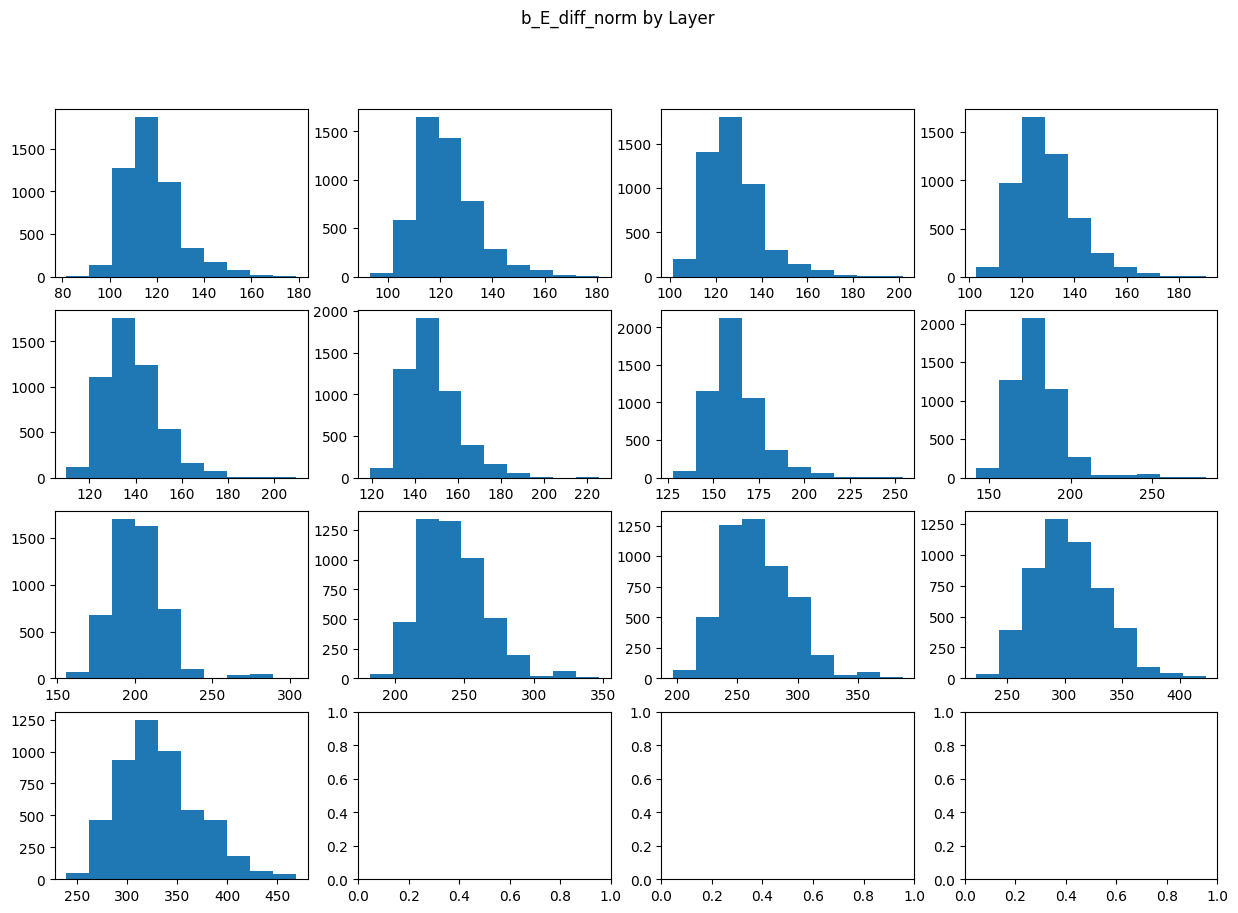

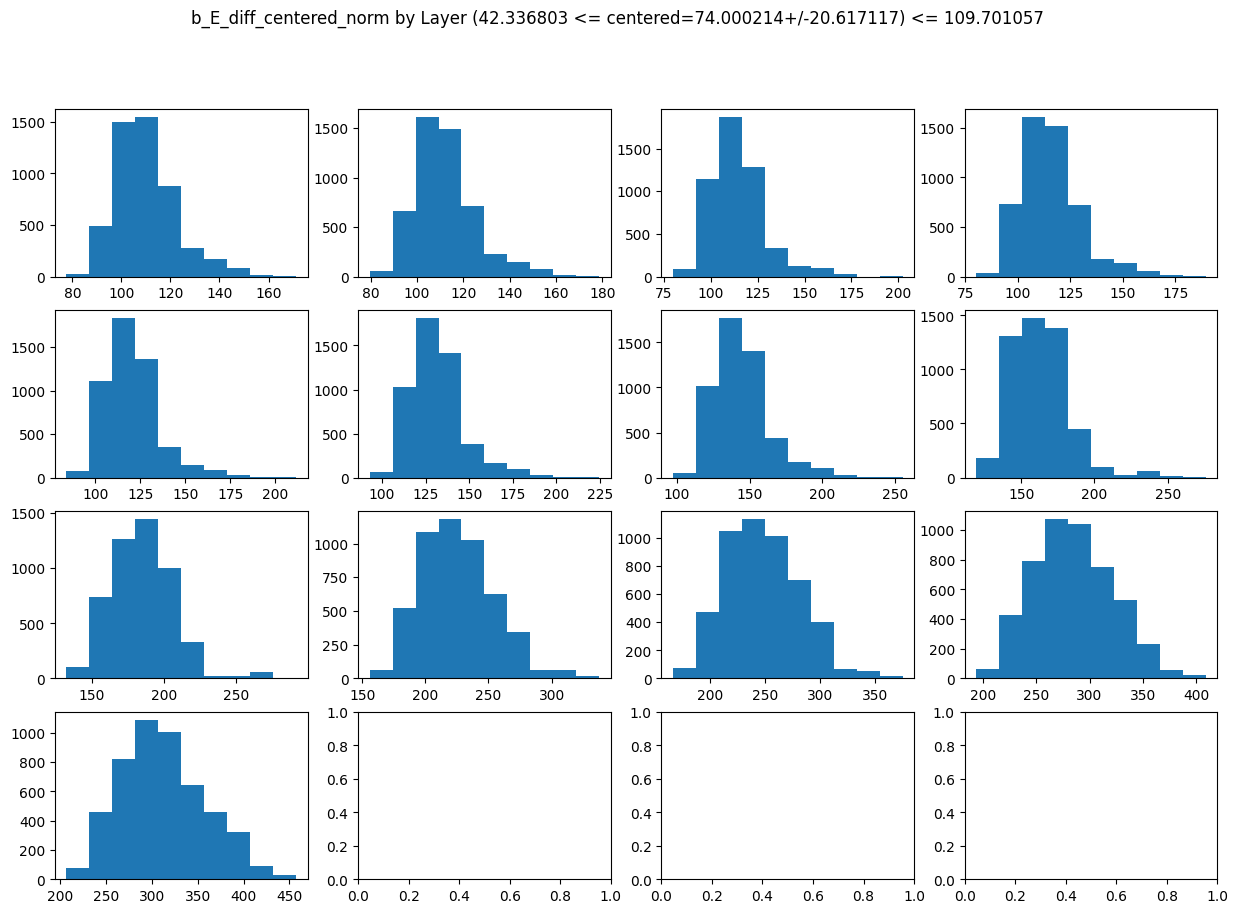

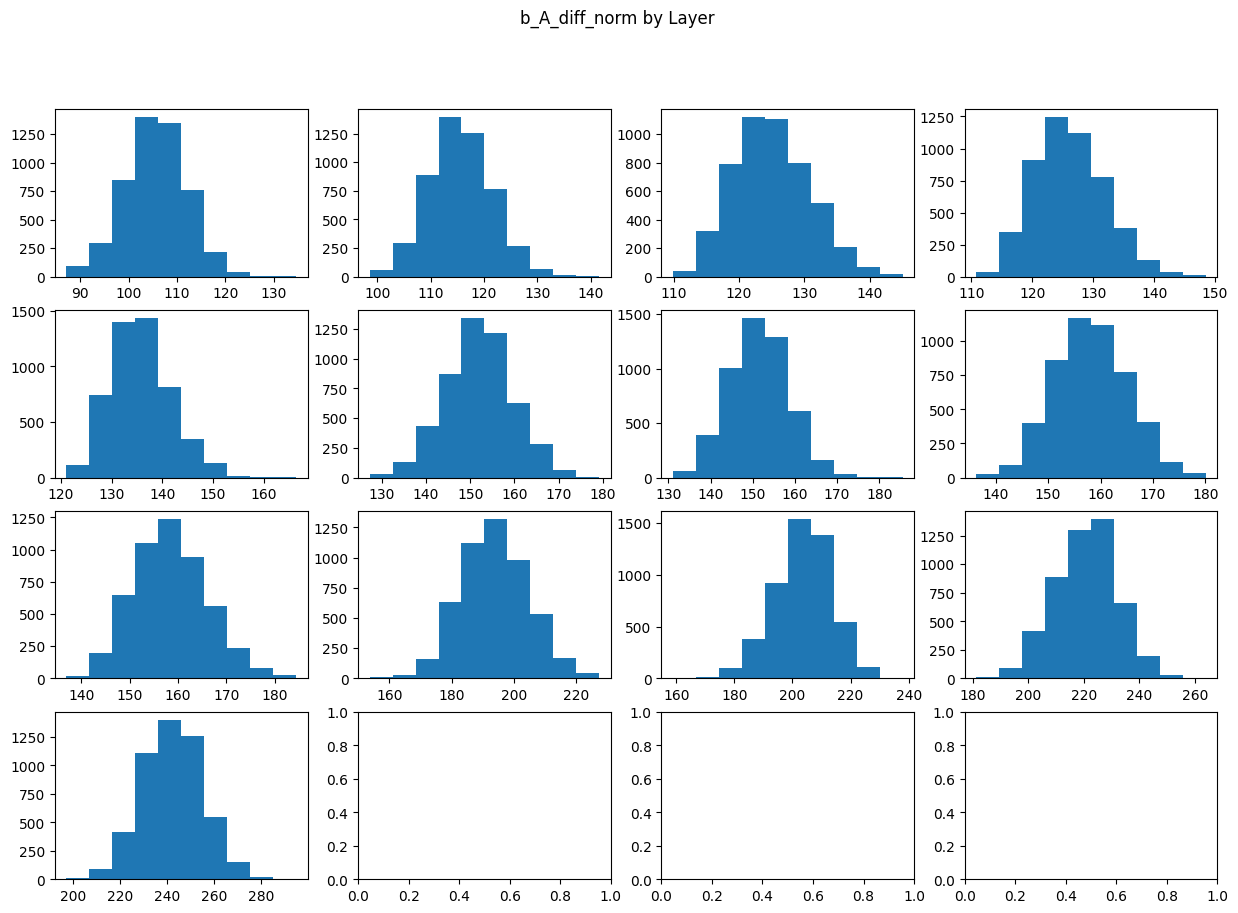

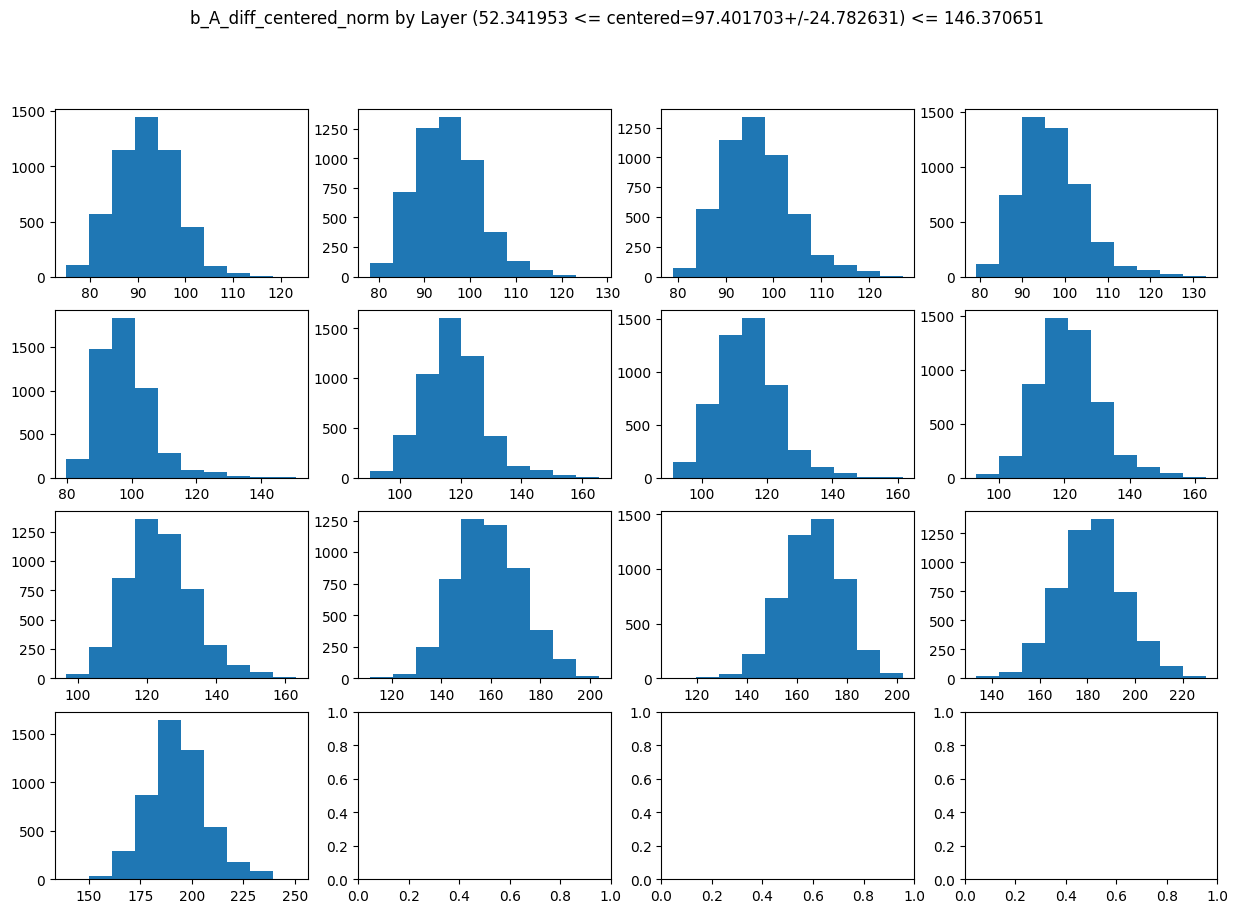

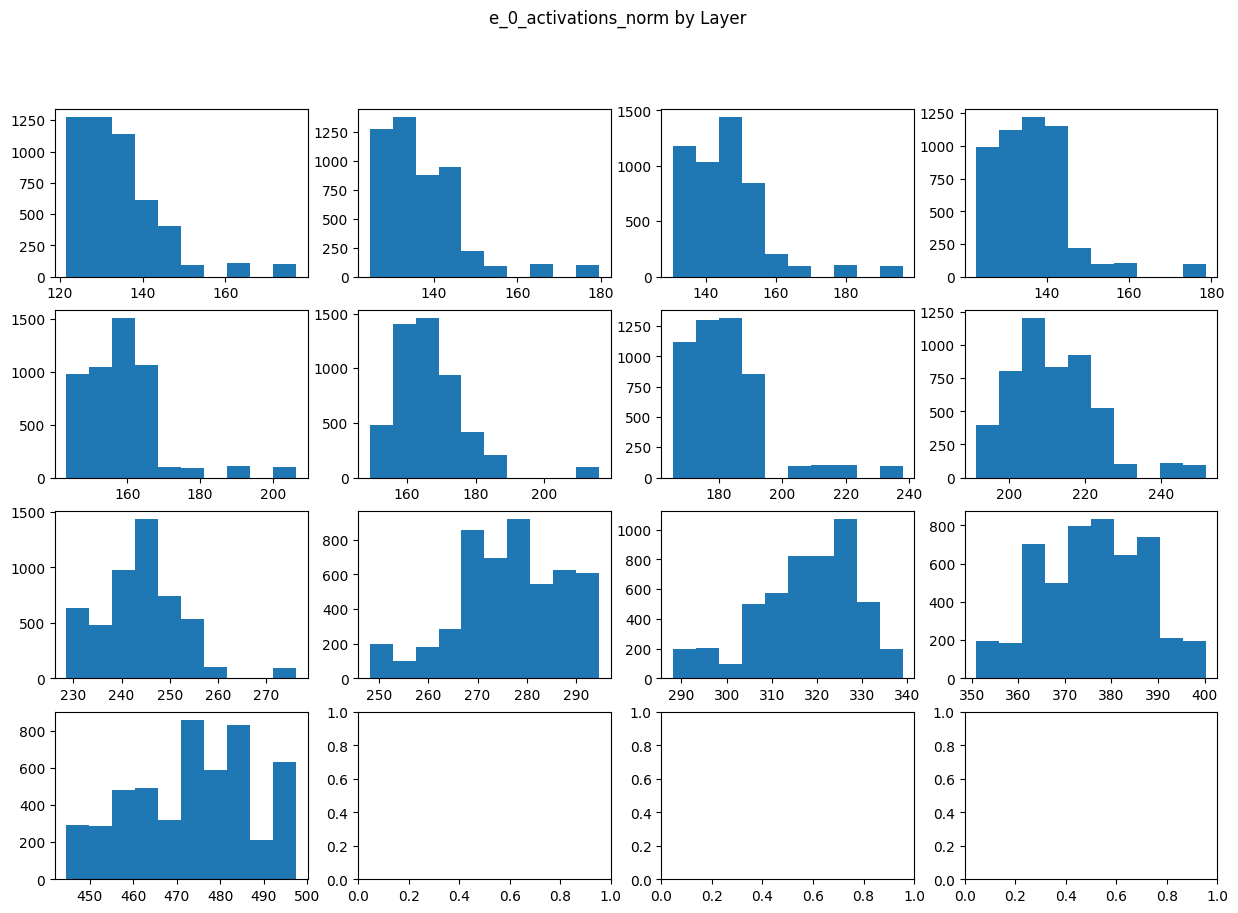

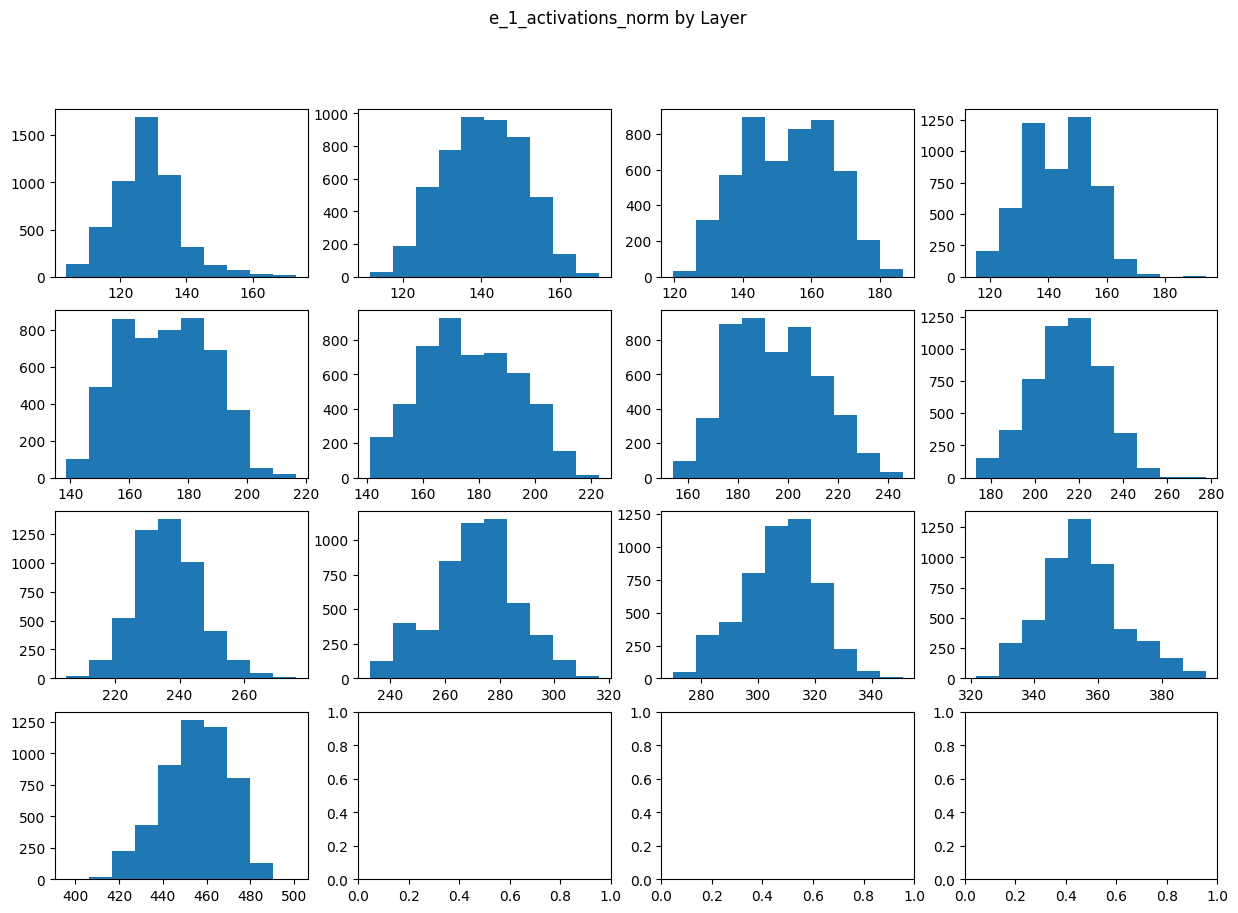

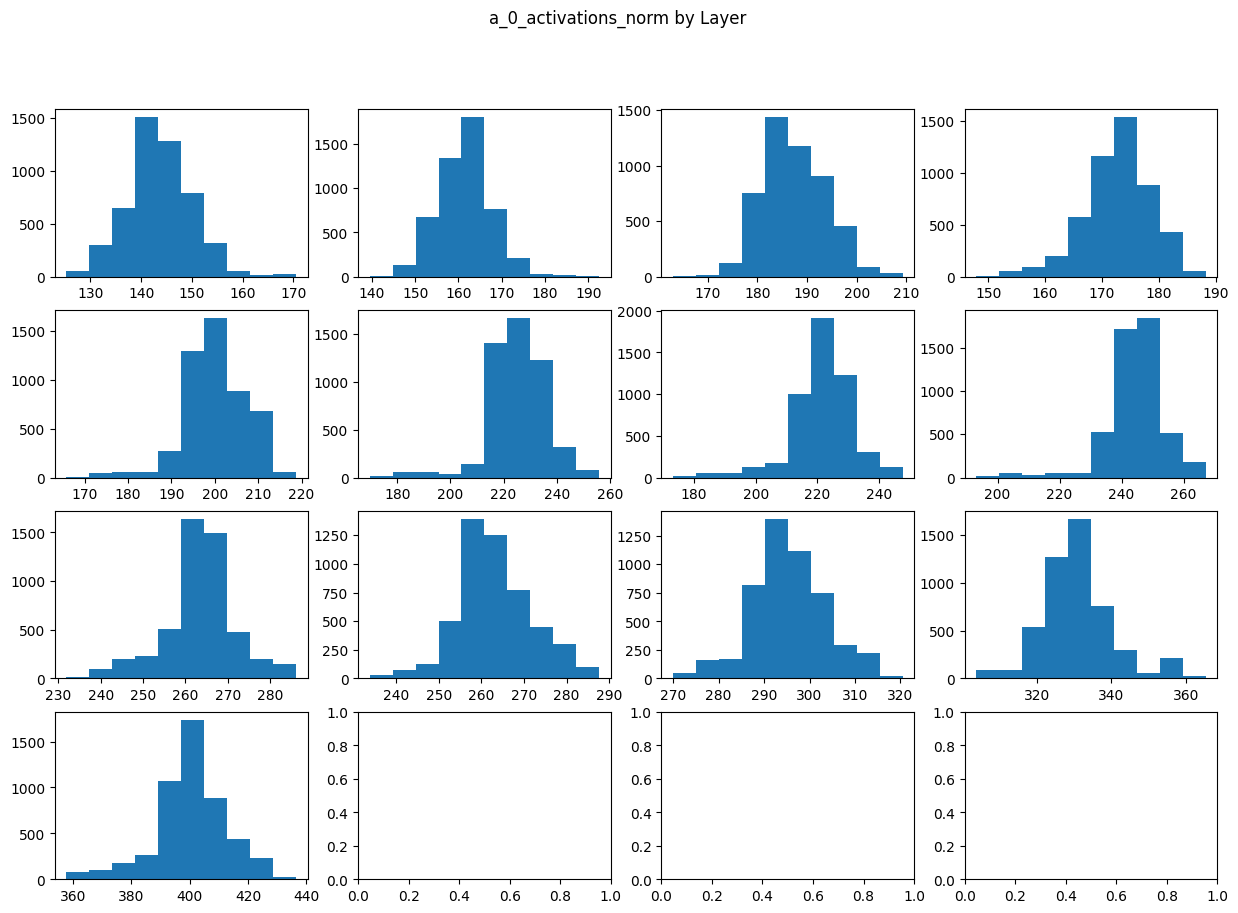

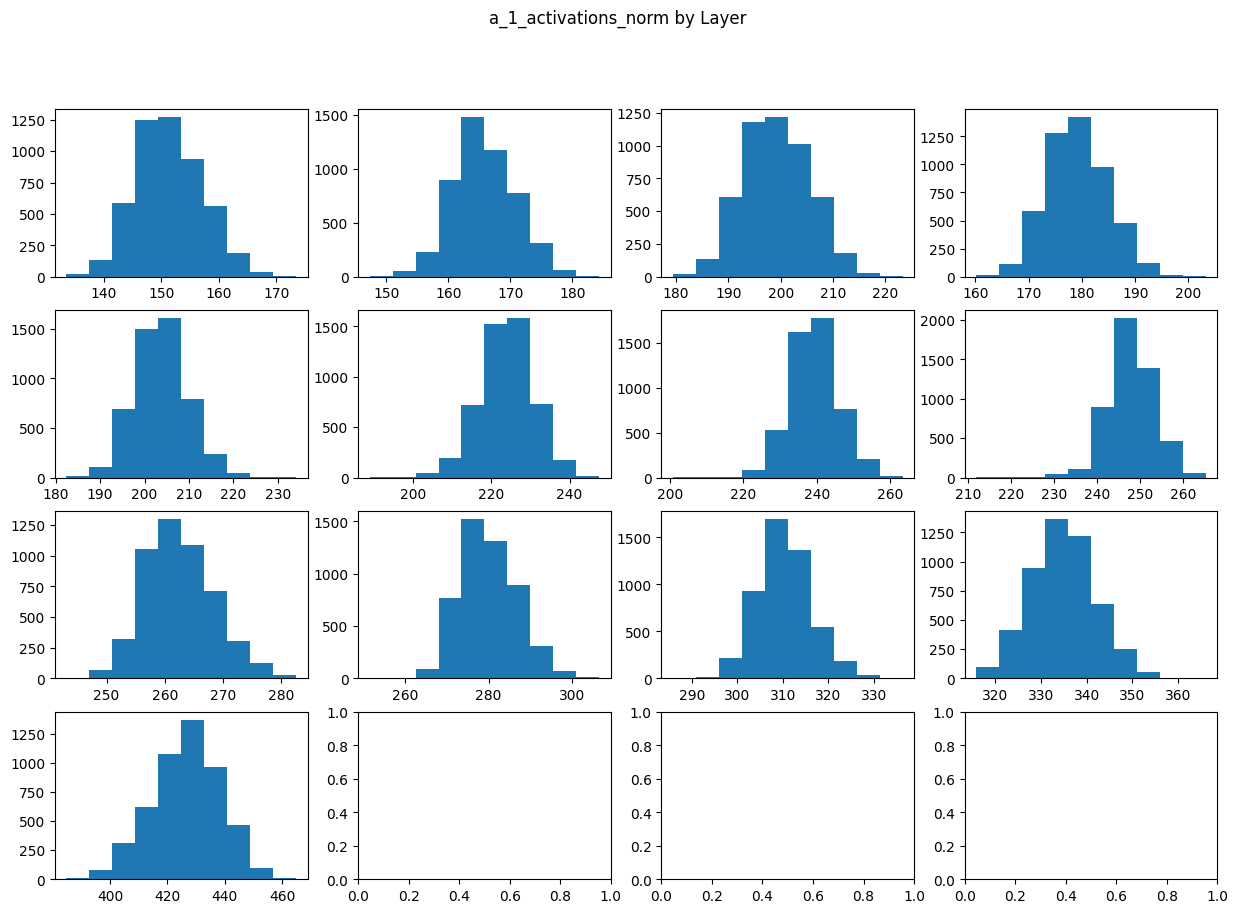

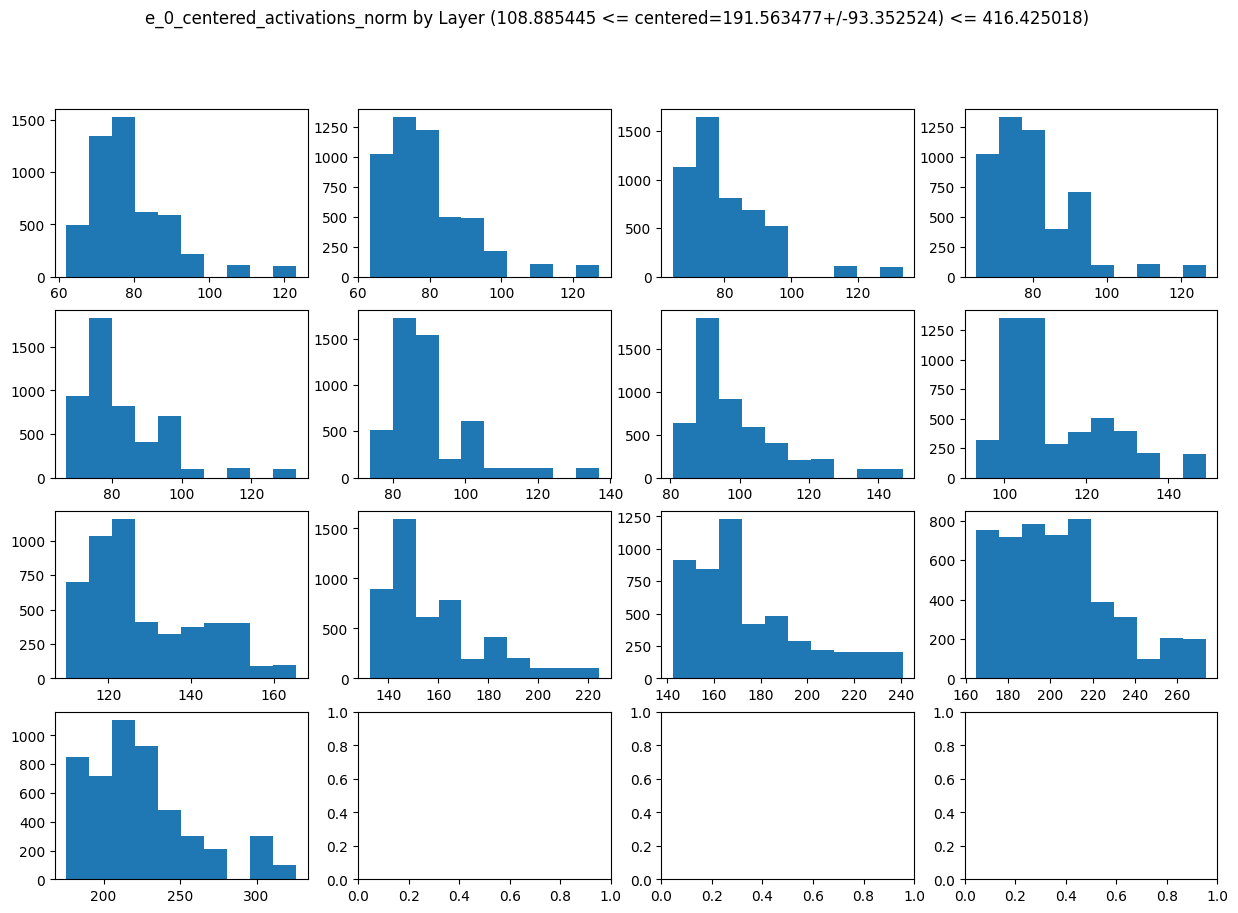

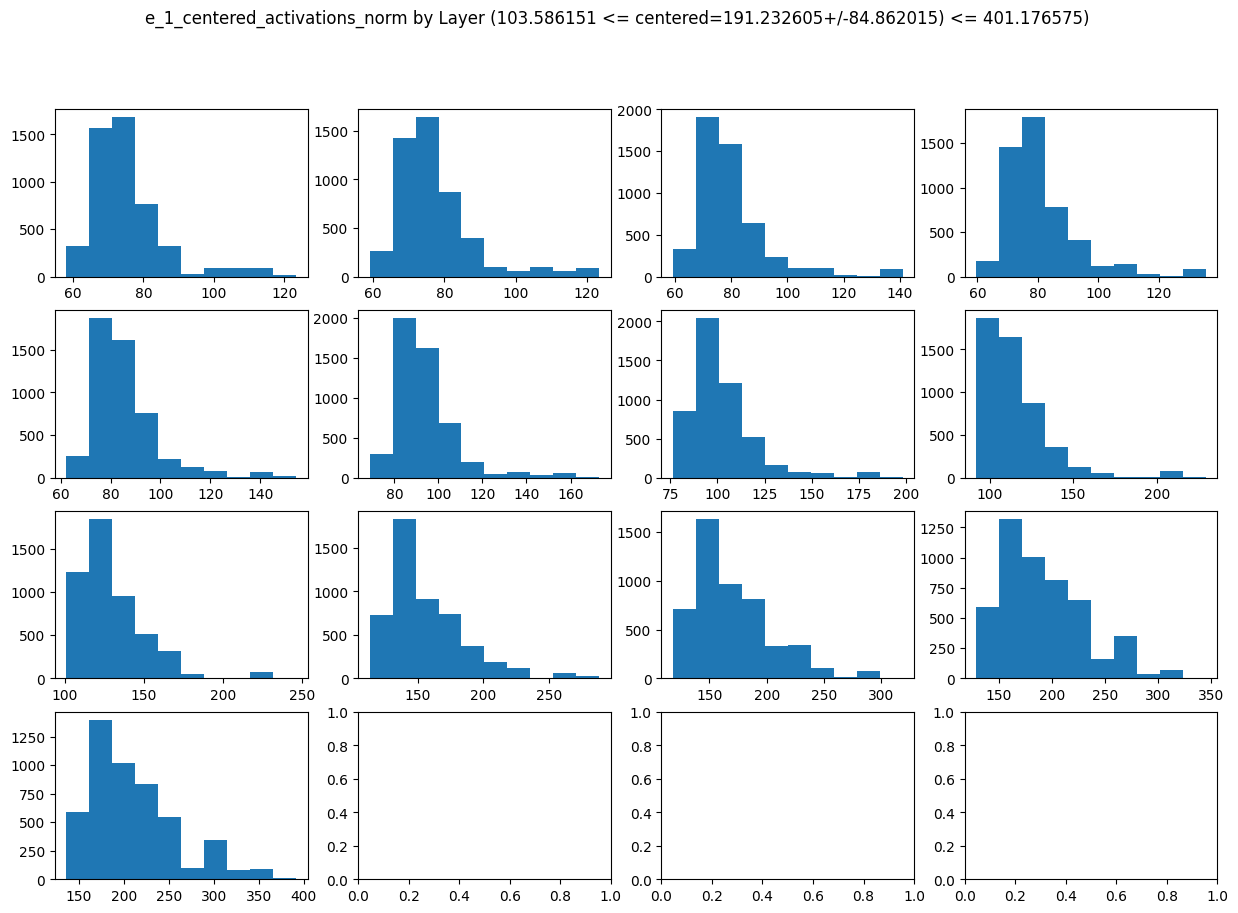

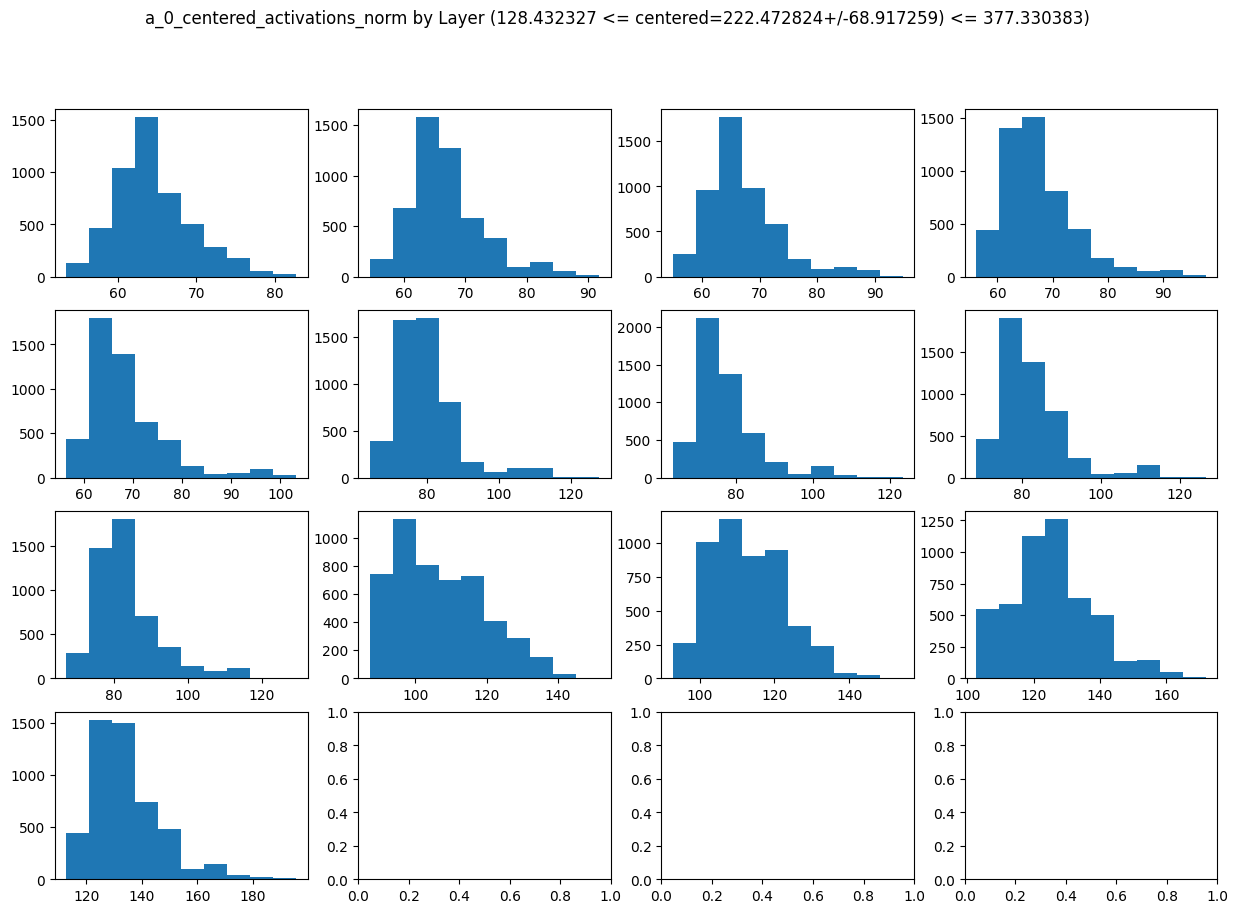

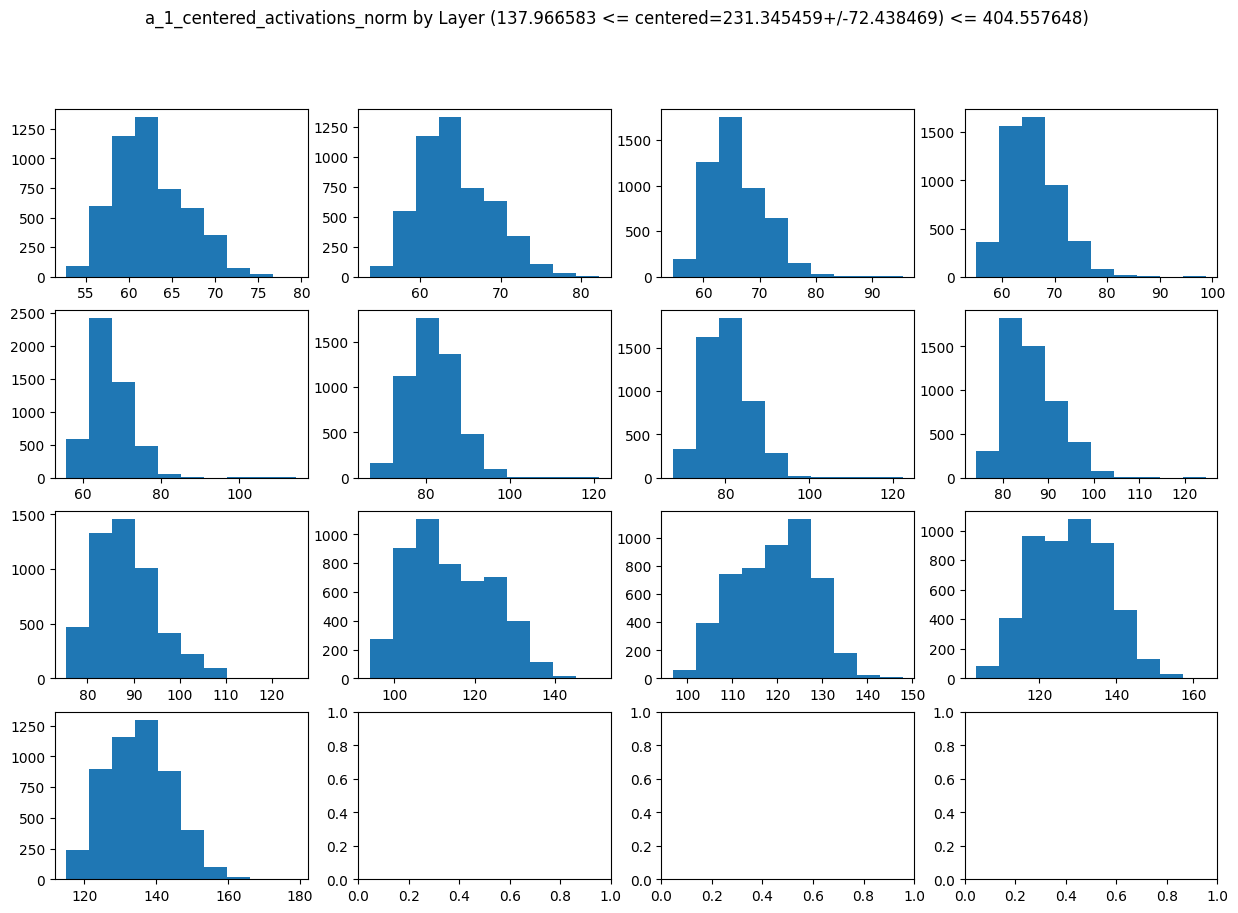

In [10]:
"""
Lol AI slop code. Anyways, the conclusion is that  the differences are fairly low norm but
similar in magnitude to regular activations... ??? They seem really small ngl.. maybe this is normal

The centers for the differences don't seem to matter too much.
"""
n_cols = 4
n_rows = math.ceil(n_layers / n_cols)
fig1, axs1 = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig2, axs2 = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig3, axs3 = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig4, axs4 = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig5, axs5 = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig6, axs6 = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig7, axs7 = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig8, axs8 = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig9, axs9 = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig10, axs10 = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig11, axs11 = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig12, axs12 = plt.subplots(n_rows, n_cols, figsize=(15, 10))
# Set titles for the figures
# b_E_diff
b_E_diff_max_mean_norm = b_E_diff_mean.norm(dim=-1).max()
b_E_diff_min_mean_norm = b_E_diff_mean.norm(dim=-1).min()
b_E_diff_mean_norm = b_E_diff_mean.norm(dim=-1).mean()
b_E_diff_stdv_mean_norm = b_E_diff_mean.norm(dim=-1).std()
# b_A_diff
b_A_diff_max_mean_norm = b_A_diff_mean.norm(dim=-1).max()
b_A_diff_min_mean_norm = b_A_diff_mean.norm(dim=-1).min()
b_A_diff_mean_norm = b_A_diff_mean.norm(dim=-1).mean()
b_A_diff_stdv_mean_norm = b_A_diff_mean.norm(dim=-1).std()
# Titles
fig1.suptitle(f'b_E_diff_norm by Layer')
fig2.suptitle(f'b_E_diff_centered_norm by Layer ({b_E_diff_min_mean_norm:4f} <= centered={b_E_diff_mean_norm:4f}+/-{b_E_diff_stdv_mean_norm:4f}) <= {b_E_diff_max_mean_norm:4f}') # fmt: skip
fig3.suptitle(f'b_A_diff_norm by Layer')
fig4.suptitle(f'b_A_diff_centered_norm by Layer ({b_A_diff_min_mean_norm:4f} <= centered={b_A_diff_mean_norm:4f}+/-{b_A_diff_stdv_mean_norm:4f}) <= {b_A_diff_max_mean_norm:4f}') # fmt: skip
assert e_0_activations.ndim == e_1_activations.ndim == a_0_activations.ndim == a_1_activations.ndim == 3
e_0_mean_activations = e_0_activations.mean(dim=1)
e_1_mean_activations = e_1_activations.mean(dim=1)
a_0_mean_activations = a_0_activations.mean(dim=1)
a_1_mean_activations = a_1_activations.mean(dim=1)
e_0_mean_activations_norm = torch.norm(e_0_mean_activations, dim=-1)
e_1_mean_activations_norm = torch.norm(e_1_mean_activations, dim=-1)
a_0_mean_activations_norm = torch.norm(a_0_mean_activations, dim=-1)
a_1_mean_activations_norm = torch.norm(a_1_mean_activations, dim=-1)
e0_activations_norm = torch.norm(e_0_activations, dim=-1)
e1_activations_norm = torch.norm(e_1_activations, dim=-1)
a0_activations_norm = torch.norm(a_0_activations, dim=-1)
a1_activations_norm = torch.norm(a_1_activations, dim=-1)
e0_centered_activations_norm = torch.norm(e_0_activations - einops.rearrange(e_0_mean_activations, "b d_model -> b 1 d_model"), dim=-1)
e1_centered_activations_norm = torch.norm(e_1_activations - einops.rearrange(e_1_mean_activations, "b d_model -> b 1 d_model"), dim=-1)
a0_centered_activations_norm = torch.norm(a_0_activations - einops.rearrange(a_0_mean_activations, "b d_model -> b 1 d_model"), dim=-1)
a1_centered_activations_norm = torch.norm(a_1_activations - einops.rearrange(a_1_mean_activations, "b d_model -> b 1 d_model"), dim=-1)
assert e0_centered_activations_norm.shape == e0_activations_norm.shape == e1_centered_activations_norm.shape == e1_activations_norm.shape
assert a0_centered_activations_norm.shape == a0_activations_norm.shape == a1_centered_activations_norm.shape == a1_activations_norm.shape
print(f"e0_activations_norm.shape: {e0_activations_norm.shape}")
print(f"e1_activations_norm.shape: {e1_activations_norm.shape}")
print(f"a0_activations_norm.shape: {a0_activations_norm.shape}")
print(f"a1_activations_norm.shape: {a1_activations_norm.shape}")
print(f"e0_centered_activations_norm.shape: {e0_centered_activations_norm.shape}")
print(f"e1_centered_activations_norm.shape: {e1_centered_activations_norm.shape}")
print(f"a0_centered_activations_norm.shape: {a0_centered_activations_norm.shape}")
print(f"a1_centered_activations_norm.shape: {a1_centered_activations_norm.shape}")
# ...
e0_mean_activations_norm_min = e_0_mean_activations_norm.min() #
e0_mean_activations_norm_max = e_0_mean_activations_norm.max()
e0_mean_activations_norm_mean = e_0_mean_activations_norm.mean()
e0_mean_activations_norm_stdv = e_0_mean_activations_norm.std()
e1_mean_activations_norm_min = e_1_mean_activations_norm.min() #
e1_mean_activations_norm_max = e_1_mean_activations_norm.max()
e1_mean_activations_norm_mean = e_1_mean_activations_norm.mean()
e1_mean_activations_norm_stdv = e_1_mean_activations_norm.std()
a0_mean_activations_norm_min = a_0_mean_activations_norm.min() #
a0_mean_activations_norm_max = a_0_mean_activations_norm.max()
a0_mean_activations_norm_mean = a_0_mean_activations_norm.mean()
a0_mean_activations_norm_stdv = a_0_mean_activations_norm.std()
a1_mean_activations_norm_min = a_1_mean_activations_norm.min() #
a1_mean_activations_norm_max = a_1_mean_activations_norm.max()
a1_mean_activations_norm_mean = a_1_mean_activations_norm.mean()
a1_mean_activations_norm_stdv = a_1_mean_activations_norm.std()
# ...
fig5.suptitle(f'e_0_activations_norm by Layer')
fig6.suptitle(f'e_1_activations_norm by Layer')
fig7.suptitle(f'a_0_activations_norm by Layer')
fig8.suptitle(f'a_1_activations_norm by Layer')
fig9.suptitle(f'e_0_centered_activations_norm by Layer ({e0_mean_activations_norm_min:4f} <= centered={e0_mean_activations_norm_mean:4f}+/-{e0_mean_activations_norm_stdv:4f}) <= {e0_mean_activations_norm_max:4f})')
fig10.suptitle(f'e_1_centered_activations_norm by Layer ({e1_mean_activations_norm_min:4f} <= centered={e1_mean_activations_norm_mean:4f}+/-{e1_mean_activations_norm_stdv:4f}) <= {e1_mean_activations_norm_max:4f})')
fig11.suptitle(f'a_0_centered_activations_norm by Layer ({a0_mean_activations_norm_min:4f} <= centered={a0_mean_activations_norm_mean:4f}+/-{a0_mean_activations_norm_stdv:4f}) <= {a0_mean_activations_norm_max:4f})')
fig12.suptitle(f'a_1_centered_activations_norm by Layer ({a1_mean_activations_norm_min:4f} <= centered={a1_mean_activations_norm_mean:4f}+/-{a1_mean_activations_norm_stdv:4f}) <= {a1_mean_activations_norm_max:4f})')
for i, ax1 in enumerate(axs1.flatten()):
    if i < n_layers:
        ax1.hist(b_E_diff_norm[i])
for i, ax2 in enumerate(axs2.flatten()):
    if i < n_layers:
        ax2.hist(b_E_diff_centered_norm[i])
for i, ax3 in enumerate(axs3.flatten()):
    if i < n_layers:
        ax3.hist(b_A_diff_norm[i])
for i, ax4 in enumerate(axs4.flatten()):
    if i < n_layers:
        ax4.hist(b_A_diff_centered_norm[i])
for i, ax5 in enumerate(axs5.flatten()):
    if i < n_layers:
        ax5.hist(e0_activations_norm[i])
for i, ax6 in enumerate(axs6.flatten()):
    if i < n_layers:
        ax6.hist(e1_activations_norm[i])
for i, ax7 in enumerate(axs7.flatten()):
    if i < n_layers:
        ax7.hist(a0_activations_norm[i])
for i, ax8 in enumerate(axs8.flatten()):
    if i < n_layers:
        ax8.hist(a1_activations_norm[i])
for i, ax9 in enumerate(axs9.flatten()):
    if i < n_layers:
        ax9.hist(e0_centered_activations_norm[i])
for i, ax10 in enumerate(axs10.flatten()):
    if i < n_layers:
        ax10.hist(e1_centered_activations_norm[i])
for i, ax11 in enumerate(axs11.flatten()):
    if i < n_layers:
        ax11.hist(a0_centered_activations_norm[i])
for i, ax12 in enumerate(axs12.flatten()):
    if i < n_layers:
        ax12.hist(a1_centered_activations_norm[i])
plt.show()


In [11]:
"""Dimensionality reduction to look for a 2-dimensional subspace"""
n_layers, n_data, d_model = b_E_diff.shape
# import torch
# from sklearn.decomposition import PCA
# import numpy as np

# def perform_pca_and_variance_explained(tensor, n_components=None):
#     """
#     Perform PCA on a tensor of shape [n_layers, n_samples, n_features]
#     and calculate variance explained for each layer.
    
#     Args:
#         tensor: torch.Tensor of shape [n_layers, n_samples, n_features]
#         n_components: Number of components to keep. If None, keep all.
    
#     Returns:
#         pca_components: List of PCA components for each layer
#         variance_explained: List of variance explained ratios for each layer
    
#     BY CLAUDE
#     """
#     n_layers = tensor.shape[0]
#     pca_components = []
#     variance_explained = []
    
#     for layer_idx in range(n_layers):
#         # Get the data for this layer
#         layer_data = tensor[layer_idx].cpu().numpy()  # Convert to numpy for sklearn
        
#         # Create and fit PCA
#         pca = PCA(n_components=n_components)
#         pca.fit(layer_data)
        
#         # Store components and variance explained
#         pca_components.append(torch.from_numpy(pca.components_))
#         variance_explained.append(pca.explained_variance_ratio_)
    
#     return pca_components, variance_explained

# # Example usage:
# # For entity differences
# e_pca_components, e_variance_explained = perform_pca_and_variance_explained(b_E_diff)

# # For attribute differences
# a_pca_components, a_variance_explained = perform_pca_and_variance_explained(b_A_diff)

# # To see the variance explained for first few components in each layer
# for layer_idx in range(len(e_variance_explained)):
#     print(f"Layer {layer_idx} - Entity PCA:")
#     print(f"First 5 components explain {np.sum(e_variance_explained[layer_idx][:5])*100:.2f}% of variance")
#     print(f"First 10 components explain {np.sum(e_variance_explained[layer_idx][:10])*100:.2f}% of variance")
#     print(f"First 50 components explain {np.sum(e_variance_explained[layer_idx][:50])*100:.2f}% of variance")
#     print()

# # Similarly for attributes
# for layer_idx in range(len(a_variance_explained)):
#     print(f"Layer {layer_idx} - Attribute PCA:")
#     print(f"First 5 components explain {np.sum(a_variance_explained[layer_idx][:5])*100:.2f}% of variance")
#     print(f"First 10 components explain {np.sum(a_variance_explained[layer_idx][:10])*100:.2f}% of variance")
#     print(f"First 50 components explain {np.sum(a_variance_explained[layer_idx][:50])*100:.2f}% of variance")
#     print()
cov_mat_E = torch.einsum("blh,blj->bhj", b_E_diff, b_E_diff)#, b=n_layers, l=n_data, h=d_model, j=d_model)
cov_mat_A = torch.einsum("blh,blj->bhj", b_A_diff, b_A_diff)#, b=n_layers, l=n_data, h=d_model, j=d_model)
print(f"cov_mat_E.shape: {cov_mat_E.shape}")
print(f"cov_mat_A.shape: {cov_mat_A.shape}")
cov_mat_eigvals_E, cov_mat_eigvecs_E = torch.linalg.eigh(cov_mat_E)
cov_mat_eigvals_A, cov_mat_eigvecs_A = torch.linalg.eigh(cov_mat_A)
print(f"cov_mat_eigvals_E.shape: {cov_mat_eigvals_E.shape}")
print(f"cov_mat_eigvecs_E.shape: {cov_mat_eigvecs_E.shape}")
print(f"cov_mat_eigvals_A.shape: {cov_mat_eigvals_A.shape}")
print(f"cov_mat_eigvecs_A.shape: {cov_mat_eigvecs_A.shape}")

cov_mat_E.shape: torch.Size([13, 2304, 2304])
cov_mat_A.shape: torch.Size([13, 2304, 2304])
cov_mat_eigvals_E.shape: torch.Size([13, 2304])
cov_mat_eigvecs_E.shape: torch.Size([13, 2304, 2304])
cov_mat_eigvals_A.shape: torch.Size([13, 2304])
cov_mat_eigvecs_A.shape: torch.Size([13, 2304, 2304])


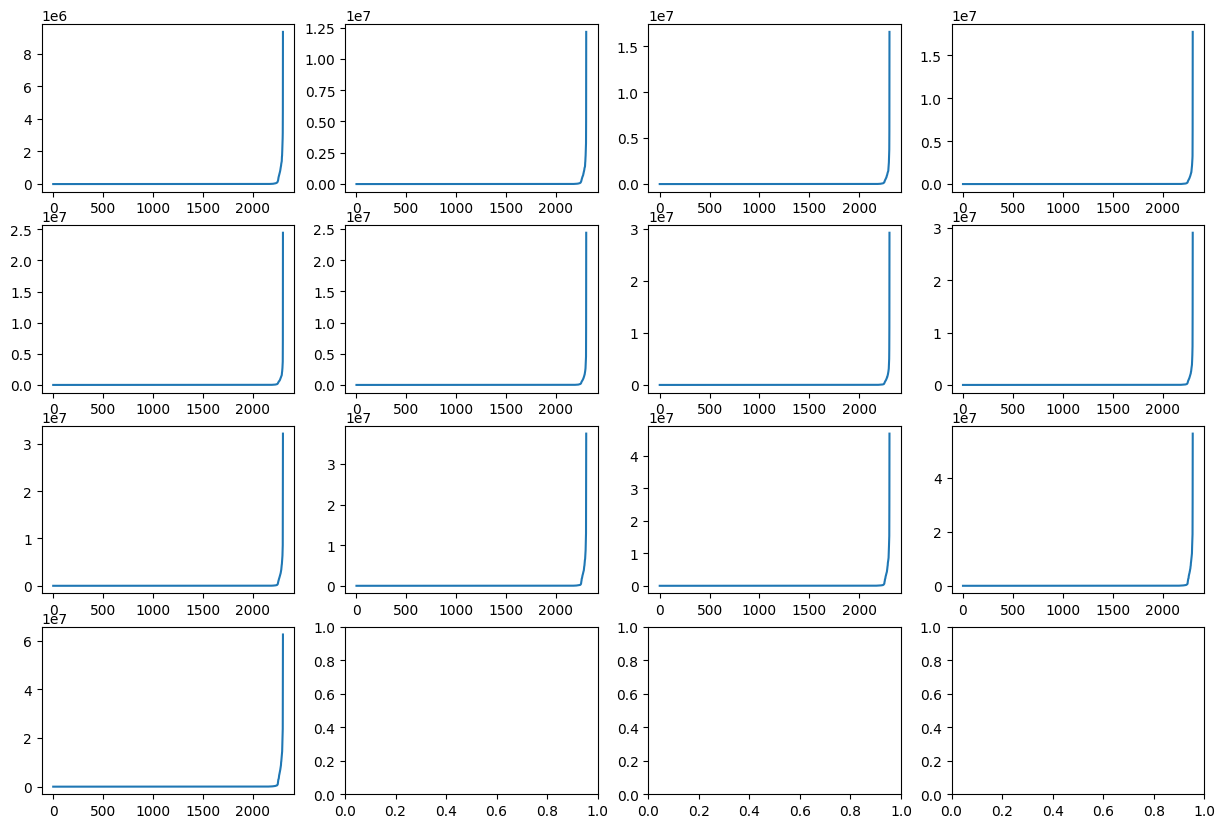

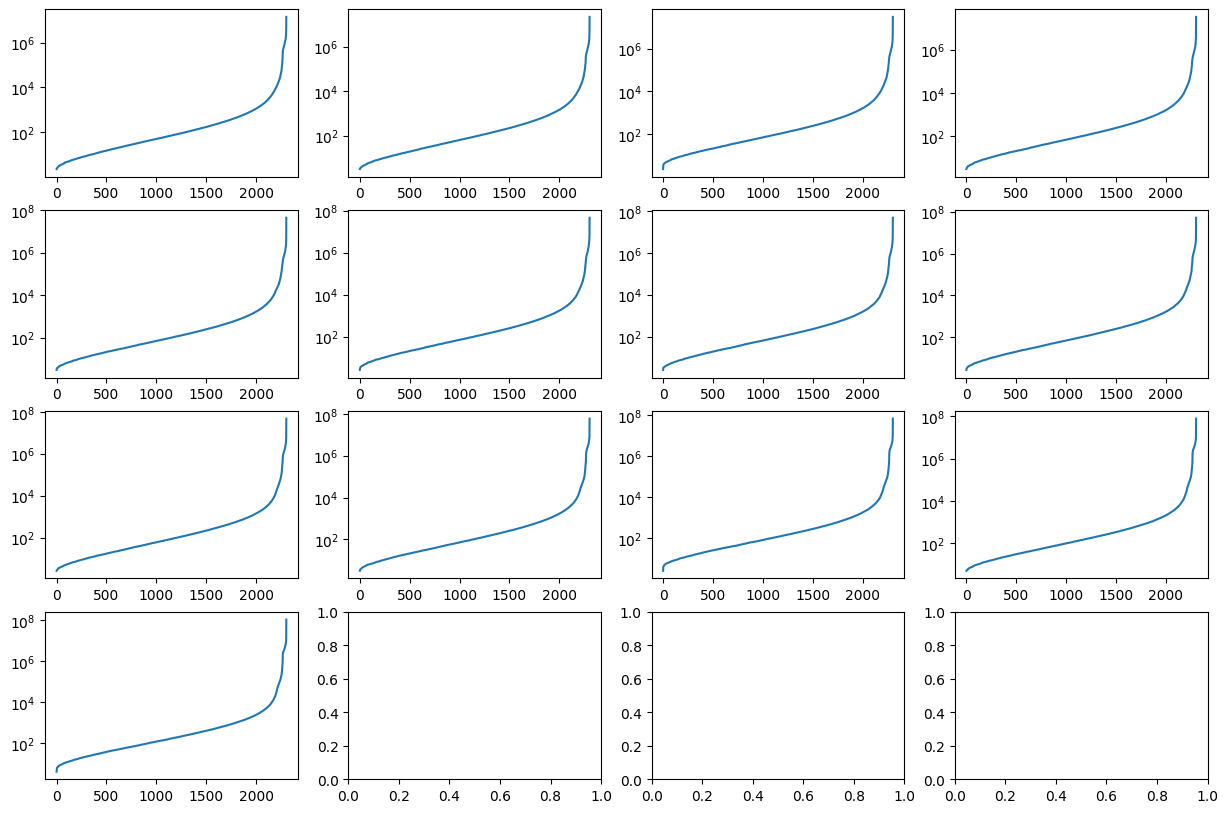

In [12]:
n_viz_col = 4
n_viz_row = math.ceil(n_layers / n_viz_col)

fig, axs1 = plt.subplots(n_viz_row, n_viz_col, figsize=(15, 10))
fig, axs2 = plt.subplots(n_viz_row, n_viz_col, figsize=(15, 10))

for i, ax1 in enumerate(axs1.flatten()):
    if i < n_layers:
        ax1.plot(cov_mat_eigvals_E[i])
for i, ax2 in enumerate(axs2.flatten()):
    if i < n_layers:
        # ax2.set_xscale('log') # not actually tooooo useful I guess
        ax2.set_yscale('log')
        ax2.plot(cov_mat_eigvals_A[i])


In [13]:
"""
The subspace extraction did not seem very good. Looking above the variance explained sucks. Below
we try to do it using the mechanism prosposed by the paper (i.e. the Hessian method).

(Possible sources of error include:
    (1) mistakes in `entity-binding.ipynb`
    (2) PCA was not the right way to go for some reason (not sure what it would be)
    (3) 
    asdflkhalsdfhlasdjfha
"""
data = torch.cat([b_E_diff, b_A_diff], dim=1)
assert data.ndim == 3
print(data.shape)
cov = torch.einsum("blh,blj->bhj", data, data)#, b=n_layers, l=n_data, h=d_model, j=d_model)
print(f"cov.shape: {cov.shape}")
cov_eigvals, cov_eigvecs = torch.linalg.eigh(cov)
print(f"cov_eigvals.shape: {cov_eigvals.shape}")
print(f"cov_eigvecs.shape: {cov_eigvecs.shape}")

torch.Size([13, 9998, 2304])
cov.shape: torch.Size([13, 2304, 2304])
cov_eigvals.shape: torch.Size([13, 2304])
cov_eigvecs.shape: torch.Size([13, 2304, 2304])


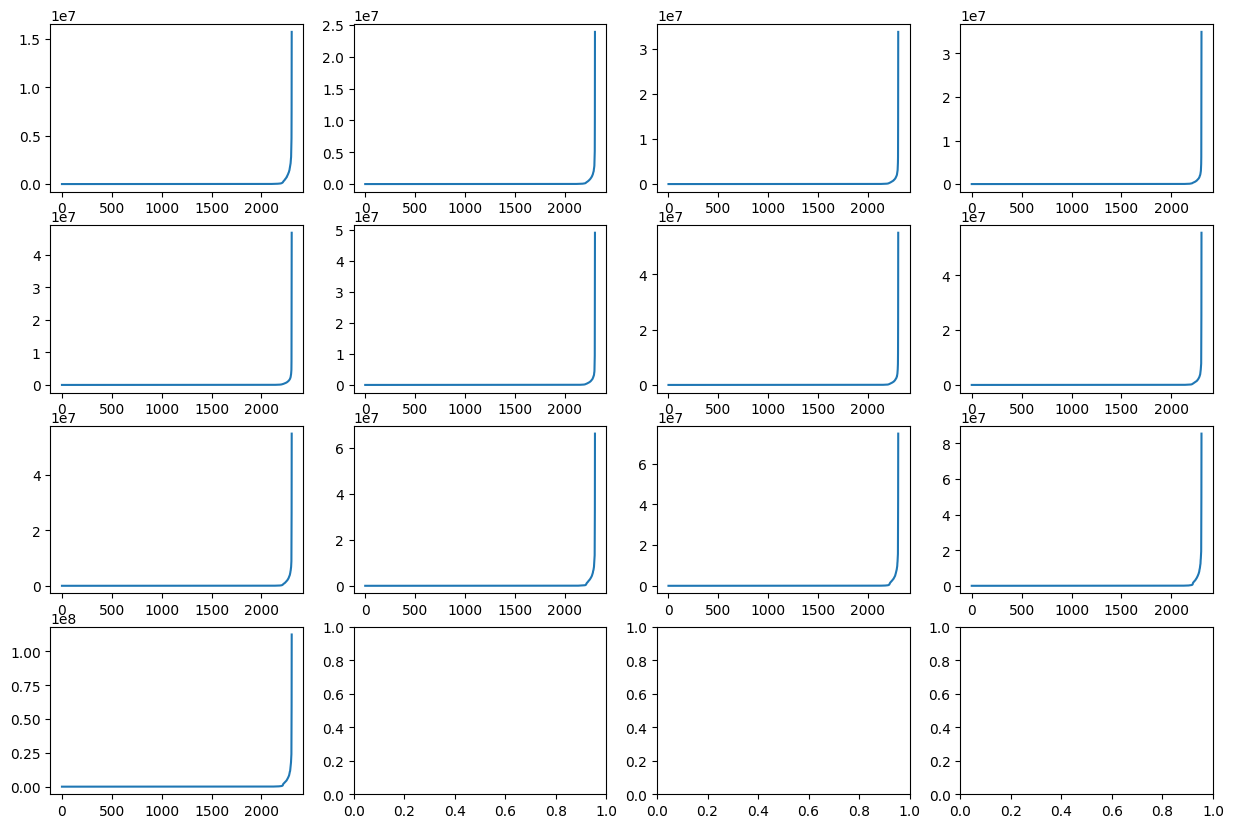

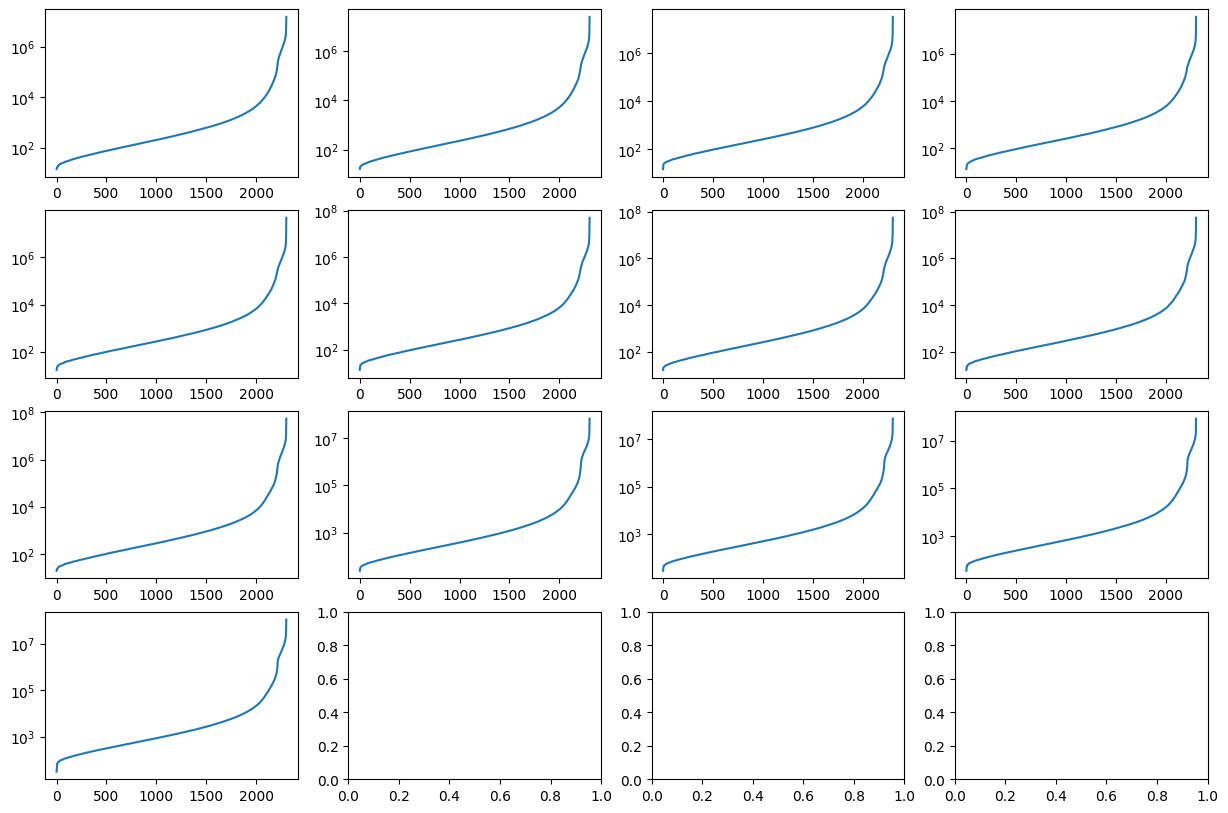

In [14]:
n_viz_col = 4
n_viz_row = math.ceil(n_layers / n_viz_col)

fig, axs3 = plt.subplots(n_viz_row, n_viz_col, figsize=(15, 10))
fig, axs4 = plt.subplots(n_viz_row, n_viz_col, figsize=(15, 10))

for i, ax3 in enumerate(axs3.flatten()):
    if i < n_layers:
        ax3.plot(cov_eigvals[i])
for i, ax4 in enumerate(axs4.flatten()):
    if i < n_layers:
        # ax2.set_xscale('log') # not actually tooooo useful I guess
        ax4.set_yscale('log')
        ax4.plot(cov_eigvals[i])


In [17]:
cov_eigvals_sorted, _ = torch.sort(cov_eigvals, dim=-1, descending=True)
total_variance = cov_eigvals.sum(dim=-1, keepdim=True)
print(f"total_variance.shape: {total_variance.shape}")
print(f"cov_eigvals_sorted.shape: {cov_eigvals_sorted.shape}")
var_explained = cov_eigvals_sorted / total_variance
need_variance_explained = 0.3
print(f"var_explained.shape: {var_explained.shape}")
ks = []
for i in range(var_explained.shape[0]):
    for k in range(1, var_explained.shape[1]):
        total_var_explained = var_explained[i, :].sum()
        cumulative_var_explained = var_explained[i, :k].sum()
        frac_var_explained = cumulative_var_explained / total_var_explained
        if frac_var_explained >= need_variance_explained or k == var_explained.shape[1] - 1:
            ks.append(k)
            break
    ks.append(k)
print("\n".join([f"layer {i} needs {k} components to explain {need_variance_explained} of variance" for i, k in enumerate(ks)]))





total_variance.shape: torch.Size([13, 1])
cov_eigvals_sorted.shape: torch.Size([13, 2304])
var_explained.shape: torch.Size([13, 2304])
layer 0 needs 6 components to explain 0.3 of variance
layer 1 needs 6 components to explain 0.3 of variance
layer 2 needs 4 components to explain 0.3 of variance
layer 3 needs 4 components to explain 0.3 of variance
layer 4 needs 2 components to explain 0.3 of variance
layer 5 needs 2 components to explain 0.3 of variance
layer 6 needs 2 components to explain 0.3 of variance
layer 7 needs 2 components to explain 0.3 of variance
layer 8 needs 2 components to explain 0.3 of variance
layer 9 needs 2 components to explain 0.3 of variance
layer 10 needs 2 components to explain 0.3 of variance
layer 11 needs 2 components to explain 0.3 of variance
layer 12 needs 2 components to explain 0.3 of variance
layer 13 needs 2 components to explain 0.3 of variance
layer 14 needs 3 components to explain 0.3 of variance
layer 15 needs 3 components to explain 0.3 of vari

In [ ]:
# N_max = 300

# sae = SAE.from_pretrained("") 
# # model

TypeError: SAE.from_pretrained() missing 1 required positional argument: 'sae_id'

In [18]:
import sae_lens
print(hook_block_idxs)
print(hook_names)
saes = [sae_lens.SAE.from_pretrained(release = "gemma-scope-2b-pt-res-canonical", sae_id = f"layer_{i}/width_16k/canonical")[0] for i in hook_block_idxs]
saes = [sae.to(device) for sae in saes]

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
['blocks.10.hook_resid_pre', 'blocks.11.hook_resid_pre', 'blocks.12.hook_resid_pre', 'blocks.13.hook_resid_pre', 'blocks.14.hook_resid_pre', 'blocks.15.hook_resid_pre', 'blocks.16.hook_resid_pre', 'blocks.17.hook_resid_pre', 'blocks.18.hook_resid_pre', 'blocks.19.hook_resid_pre', 'blocks.20.hook_resid_pre', 'blocks.21.hook_resid_pre', 'blocks.22.hook_resid_pre']


In [24]:
print(len(saes))
print(data.shape)
assert len(saes) == data.shape[0]
"""
Now a simple plan: send all the data through each say
"""

"""
Utilities that we will use later for the purpose of analyzing whether or not the SAE activations
are good representations. We will always assume that we have (1) input activations, (2) SAE model.
"""
import torch
from jaxtyping import Float, Int
from typing import Literal, Optional
from sae_lens import SAE
import sae_lens
import pydantic
import einops
import torch.nn as nn
from typing import List

class SAERepresentabilityMeasurements(pydantic.BaseModel):
    model_config = pydantic.ConfigDict(arbitrary_types_allowed = True)
    top_ks: Optional[Int[torch.Tensor, "ks"] | List[int]] = None

    # Will be filled out by the SAERepresentabilityMetrics class
    top_k_reconstruction_errors: Optional[Float[torch.Tensor, "ks batch"] | List[List[float]]] = None
    # entropies_softmax: Optional[Float[torch.Tensor, "batch"]] = None # naw
    entropies_no_softmax: Optional[Float[torch.Tensor, "batch"] | List[float]] = None

    # Entropy arguments
    # TODO(Adriano) later we will want to support multiple temperature values
    # in one experiment and somehow be able to use that for viz or something...
    # softmax_entropy_T: float = 1.0
    # softmax_entropy_atol: float = 1e-6
    atol: float = 1e-6
    units: Literal["nats", "bits"] = "bits"

class SAERepresentabilityMetrics:
    """
    A somewhat generic-ish class to basically encapsulate 
    """
    @staticmethod
    def entropy(
        vector: Float[torch.Tensor, "batch dim"],
        use_softmax: bool = False,
        softmax_temperature: float = 1.0,
        atol: float=1e-6,
        units: Literal["nats", "bits"] = "bits"
    ) -> Float[torch.Tensor, "batch"]:
        """
        Utility function that we use to compute the entropy of a vector
        (specifically a batch of vectors).
        """
        do_squeeze: bool = False
        if vector.ndim == 1:
            vector = vector.unsqueeze(0)
            do_squeeze = True
        assert vector.ndim == 2, f"vector.ndim = {vector.ndim}" # fmt: skip
        batch_size, d_dist = vector.shape

        # Ensure we can deivide/possible to make a distribution
        assert torch.all(vector.sum(dim=-1) > atol), f"vector.sum(dim=-1) = {vector.sum(dim=-1)}" # fmt: skip
        assert torch.all(vector.mean(dim=-1) > 1000*atol), f"vector.mean(dim=-1) = {vector.mean(dim=-1)}" # sanity check atol is not too small fmt: skip
        vector[vector==0] = atol # Just make a really really small number, that will be roughly negligible
        assert torch.all(vector.mean(dim=-1) > 1000*atol), f"vector.mean(dim=-1) = {vector.mean(dim=-1)}" # sanity check atol is not too small fmt: skip
        if use_softmax:
            # NOTE: softmax temperatuer could be chosen for softmax to be in bits units
            # but idt that's what we mean by bits
            raise NotImplementedError("Softmax not implemented yet") # TODO(Adriano) fix issues with 1e-100 :p
            vector = torch.softmax(vector / softmax_temperature, dim=-1)
            assert vector.shape == (batch_size, d_dist)
        else:
            vector = vector / vector.sum(dim=-1, keepdim=True)
            assert vector.shape == (batch_size, d_dist)
        # Ensure it's a distribution
        assert torch.allclose(
            vector.sum(dim=-1),
            torch.ones(vector.shape[:-1]).to(vector.device)
        ), f"vector.sum(dim=-1) = {vector.sum(dim=-1)}" # fmt: skip
        
        information = torch.log(vector) if units == "nats" else torch.log2(vector)
        assert information.shape == vector.shape, f"information.shape = {information.shape}, vector.shape = {vector.shape}" # fmt: skip
        entropies = -torch.sum(vector * information, dim=-1)
        assert entropies.shape == (batch_size,)
        assert entropies.shape == vector.shape[:-1], f"entropies.shape = {entropies.shape}, vector.shape = {vector.shape}" # fmt: skip
        if do_squeeze:
            entropies = entropies.squeeze(0)
        assert entropies.ndim == vector.ndim - 1
        return entropies
    
    @staticmethod
    @torch.no_grad()
    def top_k_reconstruction_error(
        sae: SAE,
        input_activations: torch.Tensor,
        ks: Int[torch.Tensor, "batch"]
    ) -> torch.Tensor:
        """
        Calculate the reconstructor error if we filter for ONLY the top k units and zero
        out everything else. For sparse SAEs that perform OK this should converge, quickly, to
        the regular reconstruction error.
        """
        pass

    @torch.no_grad()
    def __init__(
            self,
            sae: SAE,
            input_activations: torch.Tensor,
            measurements: SAERepresentabilityMeasurements,
            include_full_reconstruction_error: bool = True
        ):
        # Store state
        self.sae = sae
        self.input_activations = input_activations
        self.measurements = measurements

        # Make sure that the full reconstruction error is included
        assert self.measurements.top_ks is not None # need this :)
        if include_full_reconstruction_error:
            top_ks = self.measurements.top_ks
            full_k = self.sae.W_enc.shape[0]
            if full_k not in top_ks:
                top_ks = sorted(top_ks.tolist() + [full_k])
                self.measurements.top_ks = torch.Tensor(top_ks).long()
        else:
            print("WARNING: you might not be including full reconstruction error...")

        # These are the things we will fill out
        assert self.measurements.top_k_reconstruction_errors is None
        # assert self.measurements.entropies_softmax is None
        assert self.measurements.entropies_no_softmax is None

        # Make sure this is in batch x dim
        assert self.input_activations.ndim == 2, f"input_activations.ndim = {self.input_activations.ndim}" # batch, context

        # Filter for supported
        if sae.cfg.activation_fn_str != 'relu':
            raise NotImplementedError(f"Unsupported activation function: {sae.cfg.activation_fn_str}")
        if sae.cfg.architecture != 'jumprelu':
            raise NotImplementedError(f"Unsupported architecture: {sae.cfg.architecture}")

        # Make sure the SAE has the up-projection and down-projection
        # 1. Collect up-projection
        act_batch, act_dim = self.input_activations.shape
        sae_in_dim, sae_up_dim = sae.W_enc.shape
        assert sae_in_dim == sae.cfg.d_in
        assert sae_up_dim == sae.cfg.d_sae
        assert act_dim == sae_in_dim, f"act_dim = {act_dim}, sae_in_dim = {sae_in_dim}" # fmt: skip
        assert sae_up_dim > sae_in_dim, f"sae_up_dim = {sae_up_dim}, sae_in_dim = {sae_in_dim}" # fmt: skip
        assert sae.W_dec.shape == (sae_up_dim, sae_in_dim), f"sae.W_dec.shape = {sae.W_dec.shape}, (sae_up_dim, sae_in_dim) = {(sae_up_dim, sae_in_dim)}" # fmt: skip
        with torch.no_grad():
            self.up_proj = nn.Linear(in_features=sae_in_dim, out_features=sae_up_dim)
            self.up_proj.weight.data = sae.W_enc.data.T
            assert sae.b_enc.data.shape == (sae_up_dim,), f"sae.b_enc.data.shape = {sae.b_enc.data.shape}, (sae_up_dim,) = {(sae_up_dim,)}" # fmt: skip
            self.up_proj.bias.data = sae.b_enc.data
            self.up_proj.to(sae.device)
            self.up_proj.eval()
            # 2. Collect activation function
            # https://github.com/jbloomAus/SAELens/blob/929fe0657a31340584ec6078b51ff4905b881967/sae_lens/sae.py#L428
            self.act_fn = sae.activation_fn
            self.threshold = sae.threshold if hasattr(sae, "threshold") else torch.zeros_like(sae.b_enc)
            assert isinstance(self.threshold, torch.Tensor)
            assert self.threshold.ndim == 1, f"self.threshold.ndim = {self.threshold.ndim}" # fmt: skip
            assert self.threshold.shape[0] == sae_up_dim, f"self.threshold.shape[0] = {self.threshold.shape[0]}, sae_up_dim = {sae_up_dim}" # fmt: skip
            # 3. Collect down-projection
            self.down_proj = nn.Linear(in_features=sae_up_dim, out_features=sae_in_dim)
            self.down_proj.weight.data = sae.W_dec.data.T
            assert sae.b_dec.data.shape == (sae_in_dim,), f"sae.b_dec.data.shape = {sae.b_dec.data.shape}, (sae_in_dim,) = {(sae_in_dim,)}" # fmt: skip
            self.down_proj.bias.data = sae.b_dec.data
            self.down_proj.to(sae.device)
            self.down_proj.eval()

        # Sanity check that our understanding of the up and down projections is correct
        # (we will be using this for the top k reconstruction error metric(s))
        print("="*100) # XXX
        print(sae.cfg) # XXX
        print(self.up_proj) # XXX
        print(self.input_activations.shape) # XXX
        print("="*100) # XXX
        with torch.no_grad():
            _ = self.up_proj(self.input_activations)
            assert _.shape == (act_batch, sae_up_dim), f"_.shape = {_.shape}, (act_batch, sae_up_dim) = {(act_batch, sae_up_dim)}" # fmt: skip
            _ = _ * (_ > self.threshold) # check the jumprelu impl above (regular relul is jumprelu at zero I think); fmt: skip
            _ = self.act_fn(_)
            assert _.shape == (act_batch, sae_up_dim), f"_.shape = {_.shape}, (act_batch, sae_up_dim) = {(act_batch, sae_up_dim)}" # fmt: skip
            recons = sae.run_time_activation_norm_fn_out(self.down_proj(sae.apply_finetuning_scaling_factor(_)))
            e_recons = self.sae(self.input_activations)
            max_error = (recons - e_recons).abs().max()
            assert torch.allclose(
                # https://github.com/jbloomAus/SAELens/blob/929fe0657a31340584ec6078b51ff4905b881967/sae_lens/sae.py#L453
                recons,
                e_recons,
                # PLEASE KILLLLLL ME
                atol=1e-2, # apparently not always perfect?? ugh
            ), f"(max_error={max_error}) not reconstructing ok: {self.down_proj(_)}, self.input_activations = {self.input_activations}" # fmt: skip
    
    @torch.no_grad()
    def compute_measurements(self) -> SAERepresentabilityMeasurements:
        """
        Compute the measurements that we will use to analyze the representability of the SAE.
        """
        # Define shapes
        n_ks = self.measurements.top_ks.shape[0]
        input_batch, input_dim = self.input_activations.shape
        sae_dim = self.sae.cfg.d_sae

        # Get the SAE neurons
        sae_neurons = self.up_proj(self.input_activations)
        assert isinstance(self.threshold, torch.Tensor)
        assert isinstance(sae_neurons, torch.Tensor)
        sae_neurons = sae_neurons * (sae_neurons > self.threshold) # JumpReLU look above
        sae_neurons = self.act_fn(sae_neurons)
        assert sae_neurons.ndim == 2, f"sae_neurons.ndim = {sae_neurons.ndim}" # batch, dim
        assert torch.all(sae_neurons.mean(dim=-1) > self.measurements.atol), f"sae_neurons.sum(dim=-1) = {sae_neurons.sum(dim=-1)}" # fmt: skip

        # Get the softmaxes
        assert sae_neurons.shape == (input_batch, sae_dim), f"sae_neurons.shape = {sae_neurons.shape}, (input_batch, sae_dim)={(input_batch, sae_dim)}" # fmt: skip
        neurons_entropies_no_softmax = SAERepresentabilityMetrics.entropy(sae_neurons, use_softmax=False, units=self.measurements.units)
        # neurons_entropies_softmax = SAERepresentabilityMetrics.entropy(sae_neurons, use_softmax=True, units=self.measurements.units)
        # assert neurons_entropies_no_softmax.shape == neurons_entropies_softmax.shape, f"neurons_entropies_no_softmax.shape = {neurons_entropies_no_softmax.shape}, neurons_entropies_softmax.shape = {neurons_entropies_softmax.shape}" # fmt: skip
        assert neurons_entropies_no_softmax.shape == (input_batch,), f"neurons_entropies_no_softmax.shape = {neurons_entropies_no_softmax.shape}, (input_batch)={(input_batch)}" # fmt: skip

        # Get the reconstructions
        rng = (1000000 * torch.rand(1)).item()
        assert self.measurements.top_ks.ndim == 1
        sae_neurons_top_ks_reconstructions = rng * torch.ones(
            n_ks,
            input_batch,
            input_dim # NOTE: this is a RECONSTRUCTION when we apply TopK AFTER
            # the SAE
        ).to(self.input_activations.device)
        # print("top ks reconstructions shapes", sae_neurons_top_ks_reconstructions.shape) # DEBUG
        # raise Exception("stop here") # DEBUG
        for i, k in enumerate(self.measurements.top_ks):
            # Get the top k indices for each batch element
            top_k_indices = torch.topk(sae_neurons, k, dim=-1).indices
            assert top_k_indices.shape == (input_batch, k)

            # Create a mask of the top k neurons
            top_k_mask = torch.zeros_like(sae_neurons, dtype=torch.bool) # Cursor
            assert top_k_mask.shape == sae_neurons.shape
            top_k_mask.scatter_(1, top_k_indices, True) # Cursor
            assert top_k_mask.shape == sae_neurons.shape

            # Multiply the top k neurons with the mask
            sae_neurons_top_ks = sae_neurons * top_k_mask # Cursor
            assert sae_neurons_top_ks.shape == (input_batch, sae_dim), f"shape={sae_neurons_top_ks.shape}, (input_batch, sae_dim)={(input_batch, sae_dim)}, n_ks={n_ks}, k={k}"
            assert sae_neurons_top_ks_reconstructions[i, :, :].shape == (input_batch, input_dim)
            
            # Store output (look above for this act. norm stuff etc..., seems not too important)
            sae_neurons_top_ks_reconstructions[i, :, :] = self.sae.run_time_activation_norm_fn_out(
                self.down_proj(
                    self.sae.apply_finetuning_scaling_factor(
                        sae_neurons_top_ks
                    )
                )
            )
        assert torch.all(sae_neurons_top_ks_reconstructions != rng)

        reconstruction_losses = (
            sae_neurons_top_ks_reconstructions - 
            einops.rearrange(self.input_activations, "batch dim -> 1 batch dim")
        ).abs().pow(2).mean(dim=-1)
        
        # populate...
        self.measurements.top_k_reconstruction_errors = reconstruction_losses
        self.measurements.entropies_no_softmax = neurons_entropies_no_softmax
        # self.measurements.entropies_softmax = neurons_entropies_softmax

        # ret.....
        return self.measurements

print("="*50 + " [TESTING] Entropy " + "="*50)
def __test_sae_rep_metrics_entropy():
    vec = torch.Tensor([1, 1]).float().unsqueeze(0) # should be 1 bit without softmax and 0 but with softmax
    etr1 = SAERepresentabilityMetrics.entropy(vec, use_softmax=False)
    # etr2 = SAERepresentabilityMetrics.entropy(vec, use_softmax=True)
    print("entropy(vec, use_softmax=False) = ", etr1)
    # print("entropy(vec, use_softmax=True) = ", etr2)
    assert torch.allclose(etr1, torch.Tensor([1.0]))
    # assert torch.allclose(etr2, torch.Tensor([1.0]))
    # .....
    vec = torch.Tensor([[1, 2, 3, 4, 5, 0], [1, 10, 3, 4, 10, 0]]).float() # expect softmax to be lower, expect close to like 1 bit
    print("===== vec = ", vec)
    o2_1 = SAERepresentabilityMetrics.entropy(vec, use_softmax=False)
    # o2_2 = SAERepresentabilityMetrics.entropy(vec, use_softmax=True)
    print("entropy(vec, use_softmax=False) = ", o2_1)
    # print("entropy(vec, use_softmax=True) = ", o2_2)
    assert o2_1.shape == (2,), f"o2_1.shape = {o2_1.shape}, (2)={(2)}" # fmt: skip
    # assert o2_2.shape == (2,), f"o2_2.shape = {o2_2.shape}, (2)={(2)}" # fmt: skip
    # ......
    vec = torch.Tensor([0.01, 0.01, 0.01, 0.01, 0.01, 0.94]).float().unsqueeze(0) # expect basically 0 entropy and softmax super close to zero
    print("===== vec = ", vec)
    print("entropy(vec, use_softmax=False) = ", SAERepresentabilityMetrics.entropy(vec, use_softmax=False))
    # print("entropy(vec, use_softmax=True) = ", SAERepresentabilityMetrics.entropy(vec, use_softmax=True))
__test_sae_rep_metrics_entropy()
print("="*50 + " [OK] Entropy Function Testing has passed " + "="*50)

print("="*50 + " [TESTING] Top K Reconstruction Error " + "="*50)
def __test_sae_rep_metrics_top_k_reconstruction_error():
    # Create an SAE for testing :)
    device = "cuda:0"
    sae, _, _ = SAE.from_pretrained(release = "gemma-scope-2b-pt-res-canonical", sae_id = f"layer_10/width_16k/canonical")
    sae.eval()
    sae.to(device)
    print("==== SAE FACTS ====") # DEBUG
    print(dict(sae.named_parameters()).keys()) # DEBUG
    print(dict(sae.named_modules()).keys()) # DEBUG
    print(sae.threshold) # DEBUG
    # Create some dummy activations
    batch_size = 5
    act_dim = min(sae.W_enc.shape)
    dummy_activations = 300 * torch.randn(batch_size, act_dim, device = device)
    # Create the metrics
    measurements = SAERepresentabilityMeasurements(top_ks = torch.Tensor([10]).long())
    metrics = SAERepresentabilityMetrics(sae, dummy_activations, measurements)
    measurements = metrics.compute_measurements()
    # Ensure output computed ok
    assert measurements.top_k_reconstruction_errors is not None
    assert measurements.entropies_no_softmax is not None
    # assert measurements.entropies_softmax is not None
    # Ensure top ks ok
    assert measurements.top_ks.ndim == 1
    # 2 ks incl. full
    assert measurements.top_ks.shape == (2,), f"measurements.top_ks.shape = {measurements.top_ks.shape}" # fmt: skip
    assert measurements.top_k_reconstruction_errors.shape == (2, batch_size), f"measurements.top_k_reconstruction_errors.shape = {measurements.top_k_reconstruction_errors.shape}" # fmt: skip
    # Ensure entropies ok
    assert measurements.entropies_no_softmax.shape == (batch_size,), f"measurements.entropies_no_softmax.shape = {measurements.entropies_no_softmax.shape}" # fmt: skip
    # assert measurements.entropies_softmax.shape == (batch_size,), f"measurements.entropies_softmax.shape = {measurements.entropies_softmax.shape}" # fmt: skip
    assert torch.all(measurements.entropies_no_softmax > 0), f"measurements.entropies_no_softmax = {measurements.entropies_no_softmax}" # fmt: skip
    # assert torch.all(measurements.entropies_softmax > 0), f"measurements.entropies_softmax = {measurements.entropies_softmax}" # fmt: skip
    # Print out for debugging
    measurements.top_ks = None
    measurements.top_k_reconstruction_errors = measurements.top_k_reconstruction_errors.tolist()
    measurements.entropies_no_softmax = measurements.entropies_no_softmax.tolist()
    # measurements.entropies_softmax = None
    # (pretty print)
    print(measurements.model_dump_json(indent=4))
__test_sae_rep_metrics_top_k_reconstruction_error()
print("="*50 + " [OK] Measuremnets/Metrics Class Testing has passed " + "="*50)

# XXX todos
# [Baseline] 1. be able to calculate the metrics on random data for multiple different SAEs and plot them effectively (should plot as baselines)
# [Baseline] 2. be able to collect some real activations, but not those tokens and store em or something... and calculate the metrics (as baselines)
# 3. be able to use the PCA from `susbspace_extraction`) to do ^ and get a preliminary plot (we will do more/better later)
# 4. be able to use the hessian algorithm etc... to get some real vectors (then we will need to confirm they steer correctly... but
#    maybe jim can finish that???)

13
torch.Size([13, 9998, 2304])
================================================== [TESTING] Entropy ==================================================
entropy(vec, use_softmax=False) =  tensor([1.])
===== vec =  tensor([[ 1.,  2.,  3.,  4.,  5.,  0.],
        [ 1., 10.,  3.,  4., 10.,  0.]])
entropy(vec, use_softmax=False) =  tensor([2.1493, 1.9790])
===== vec =  tensor([[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.9400]])
entropy(vec, use_softmax=False) =  tensor([0.4058])
================================================== [OK] Entropy Function Testing has passed ==================================================
================================================== [TESTING] Top K Reconstruction Error ==================================================
==== SAE FACTS ====
dict_keys(['threshold', 'b_enc', 'W_dec', 'W_enc', 'b_dec'])
dict_keys(['', 'activation_fn', 'hook_sae_input', 'hook_sae_acts_pre', 'hook_sae_acts_post', 'hook_sae_output', 'hook_sae_recons', 'hook_sae_error'])
Parameter

In [32]:
print(data.shape)
print(data[0].shape) # batch x dim

torch.Size([13, 9998, 2304])
torch.Size([9998, 2304])


In [25]:
# top_ks: Optional[Int[torch.Tensor, "ks"] | List[int]] = None

# # Will be filled out by the SAERepresentabilityMetrics class
# top_k_reconstruction_errors: Optional[Float[torch.Tensor, "ks batch"] | List[List[float]]] = None
# # entropies_softmax: Optional[Float[torch.Tensor, "batch"]] = None # naw
# entropies_no_softmax: Optional[Float[torch.Tensor, "batch"] | List[float]] = None
# atol: float = 1e-6
# units: Literal["nats", "bits"] = "bits"
# @torch.no_grad()
# def __init__(
#         self,
#         sae: SAE,
#         input_activations: torch.Tensor,
#         measurements: SAERepresentabilityMeasurements,
#         include_full_reconstruction_error: bool = True
metrics = [
    SAERepresentabilityMetrics(
        sae=saes[i], # one per layerr
        input_activations=data[i].to(saes[i].device), # these are all the datapoints for that layer
        # NOTE: all of them should be making it above 256
        measurements=SAERepresentabilityMeasurements(top_ks=torch.Tensor([1, 2, 4, 16, 32, 64, 128, 256]).long()), # otherwise defaults
        include_full_reconstruction_error=True,
    )
    for i in range(len(saes))
]

SAEConfig(architecture='jumprelu', d_in=2304, d_sae=16384, activation_fn_str='relu', apply_b_dec_to_input=False, finetuning_scaling_factor=False, context_size=1024, model_name='gemma-2-2b', hook_name='blocks.10.hook_resid_post', hook_layer=10, hook_head_index=None, prepend_bos=True, dataset_path='monology/pile-uncopyrighted', dataset_trust_remote_code=True, normalize_activations=None, dtype='float32', device='cuda:0', sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id='gemma-2-2b/10-gemmascope-res-16k', model_from_pretrained_kwargs={}, seqpos_slice=(None,))
Linear(in_features=2304, out_features=16384, bias=True)
torch.Size([9998, 2304])
SAEConfig(architecture='jumprelu', d_in=2304, d_sae=16384, activation_fn_str='relu', apply_b_dec_to_input=False, finetuning_scaling_factor=False, context_size=1024, model_name='gemma-2-2b', hook_name='blocks.11.hook_resid_post', hook_layer=11, hook_head_index=None, prepend_bos=True, dataset_path='monology/pile-uncopyrighted', datase

In [26]:
measurements = [
    m.compute_measurements() for m in tqdm.tqdm(metrics)
]







100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


top_ks shape (9,)
entropies shape (13, 9998)
reconstruction_errors shape (13, 9, 9998)


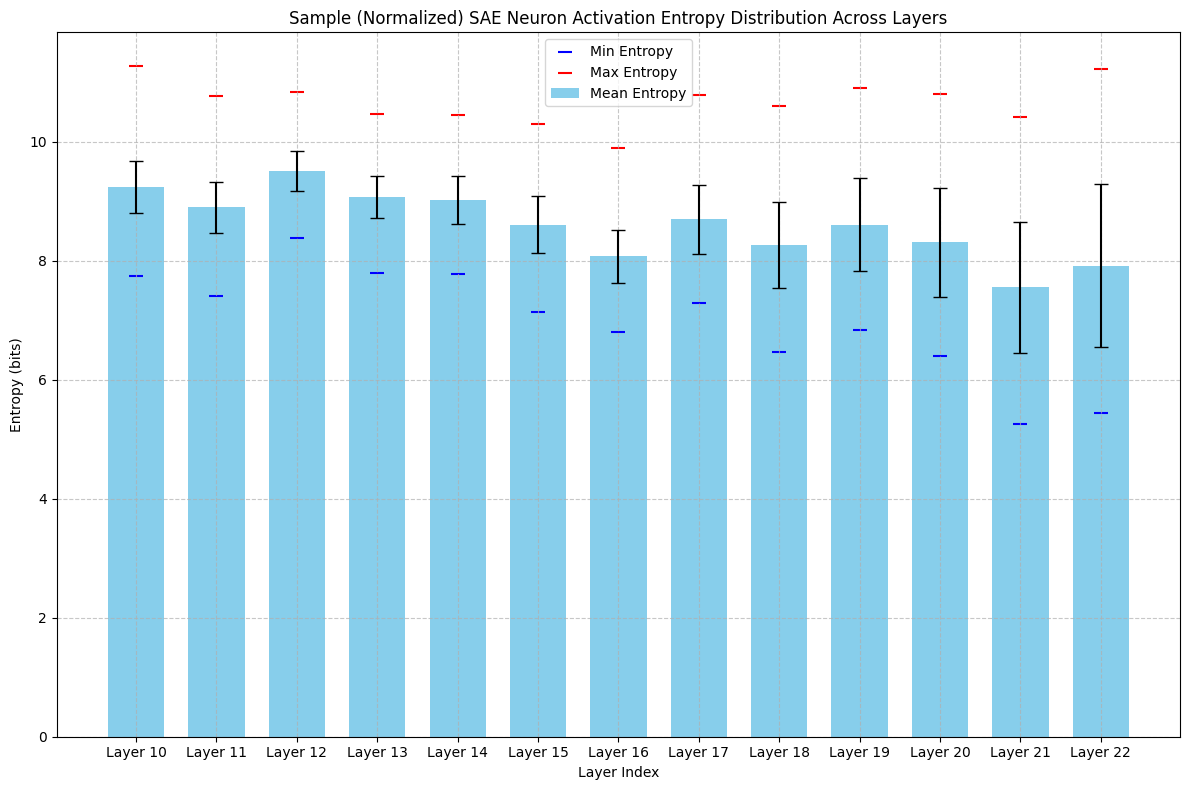

In [34]:
top_ks = measurements[0].top_ks
assert all([
    torch.allclose(m.top_ks, top_ks) for m in measurements
])
entropies = torch.stack([
    m.entropies_no_softmax for m in measurements
])
mean_entropies = entropies.mean(dim=-1)
std_entropies = entropies.std(dim=-1)
min_entropies, _ = entropies.min(dim=-1)
max_entropies, _ = entropies.max(dim=-1)
reconstruction_errors = torch.stack([
    m.top_k_reconstruction_errors for m in measurements
])
top_ks = top_ks.detach().cpu().numpy()
entropies = entropies.detach().cpu().numpy()
mean_entropies = mean_entropies.detach().cpu().numpy()
min_entropies = min_entropies.detach().cpu().numpy()
max_entropies = max_entropies.detach().cpu().numpy()
std_entropies = std_entropies.detach().cpu().numpy()
reconstruction_errors = reconstruction_errors.detach().cpu().numpy()
print("top_ks shape", top_ks.shape)
print("entropies shape", entropies.shape)
print("reconstruction_errors shape", reconstruction_errors.shape)

# Plot entropies as a bar chart with error bars
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))
x = np.arange(len(mean_entropies))
width = 0.7

plt.bar(x, mean_entropies, width, yerr=std_entropies, capsize=5, 
        color='skyblue', label='Mean Entropy')

# Add min/max as scatter points
plt.scatter(x, min_entropies, color='blue', marker='_', s=100, label='Min Entropy')
plt.scatter(x, max_entropies, color='red', marker='_', s=100, label='Max Entropy')

plt.xlabel('Layer Index')
plt.ylabel('Entropy (bits)')
plt.title('Sample (Normalized) SAE Neuron Activation Entropy Distribution Across Layers')
plt.xticks(x, [f'Layer {i+10}' for i in range(len(mean_entropies))])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


(13, 9)
(13, 9)
(13, 9)
(13, 9)


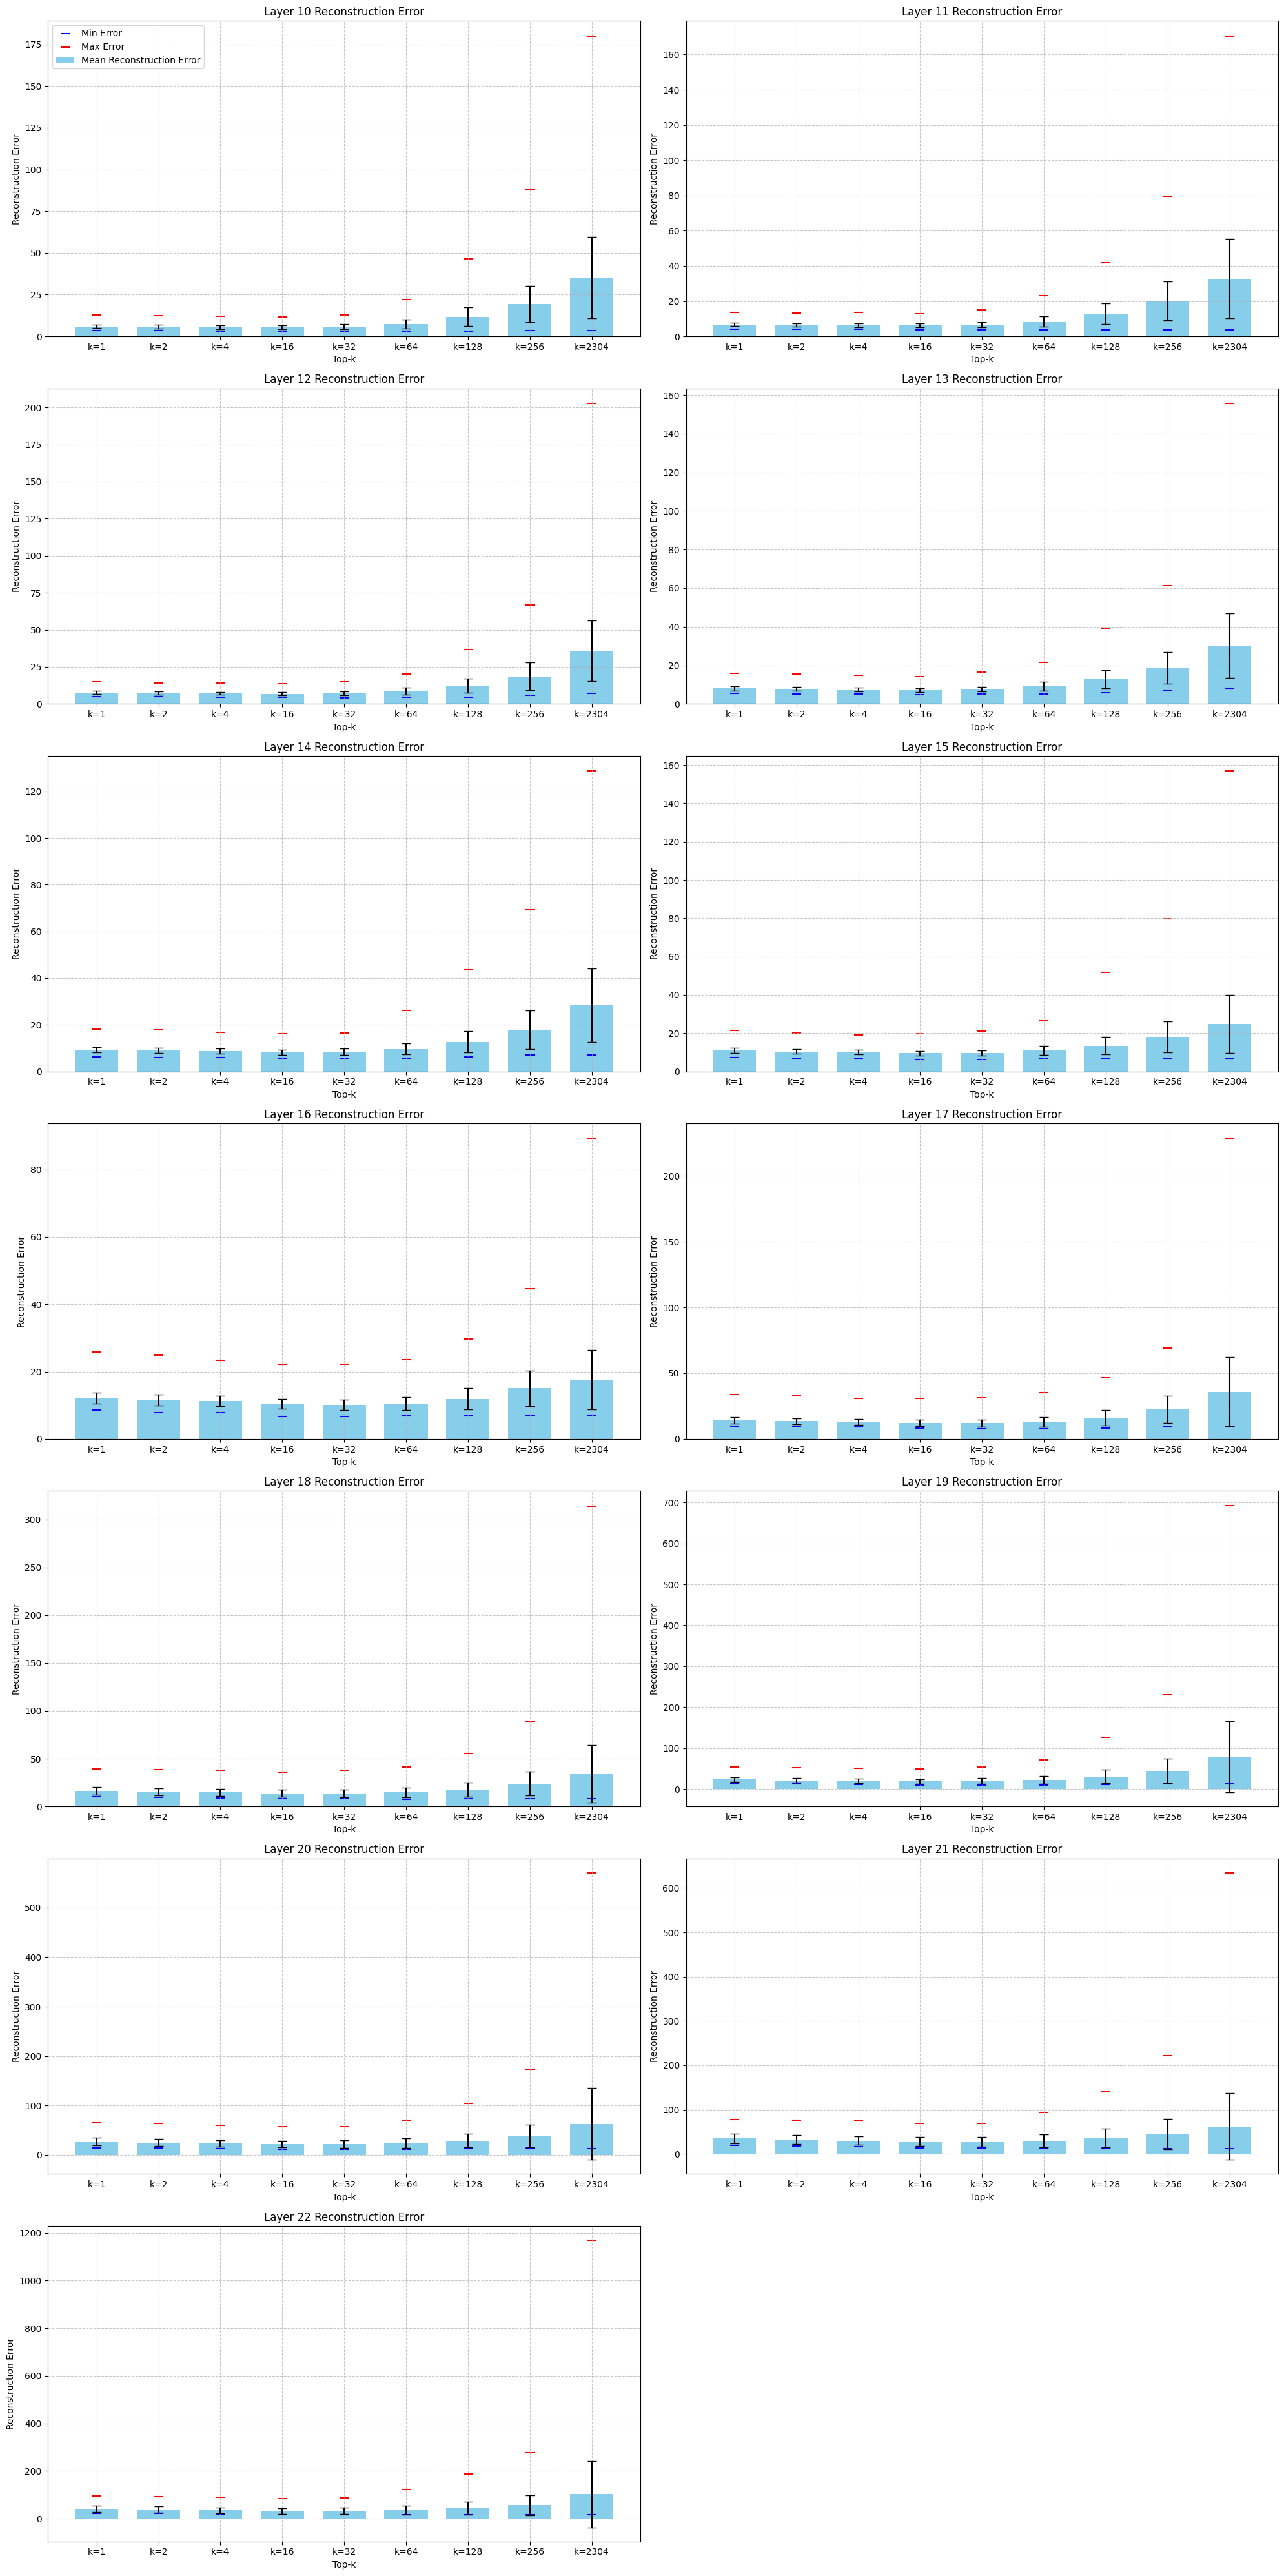

In [40]:
mean_reconstruction_error_per_k = reconstruction_errors.mean(axis=-1)
stdev_reconstruction_error_per_k = reconstruction_errors.std(axis=-1)
min_reconstruction_error_per_k = reconstruction_errors.min(axis=-1)
max_reconstruction_error_per_k = reconstruction_errors.max(axis=-1)
print(mean_reconstruction_error_per_k.shape)
print(stdev_reconstruction_error_per_k.shape)
print(min_reconstruction_error_per_k.shape)
print(max_reconstruction_error_per_k.shape)
# Create 13 bar charts, one for each layer
plt.figure(figsize=(20, 40))

for i in range(len(mean_reconstruction_error_per_k)):
    plt.subplot(7, 2, i+1)
    
    x = np.arange(len(mean_reconstruction_error_per_k[i]))
    width = 0.7
    
    # Plot bars with error bars
    plt.bar(x, mean_reconstruction_error_per_k[i], width, 
            yerr=stdev_reconstruction_error_per_k[i], 
            capsize=5, color='skyblue', label='Mean Reconstruction Error')
    
    # Add min/max as scatter points
    plt.scatter(x, min_reconstruction_error_per_k[i], color='blue', 
                marker='_', s=100, label='Min Error')
    plt.scatter(x, max_reconstruction_error_per_k[i], color='red', 
                marker='_', s=100, label='Max Error')
    
    plt.xlabel('Top-k')
    plt.ylabel('Reconstruction Error')
    plt.title(f'Layer {i+10} Reconstruction Error')
    plt.xticks(x, [f'k={top_ks[j]}' for j in range(len(top_ks))])
    
    if i == 0:  # Only add legend to the first plot to avoid clutter
        plt.legend()
    
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(top_ks)

In [53]:
"""
The goal is to see here if a lot of neurons are active or not
"""
top_2_cov_eigvecs = cov_eigvecs[:, :2, :] # 2 rows
top_2_cov_eigvecs[0].shape
rotated_vecs = []
for i in range(top_2_cov_eigvecs.shape[0]):
    these_rotated_vecs = []
    basis_vecs = top_2_cov_eigvecs[i]
    dtheta = 2 * torch.pi / 360
    thetas = torch.arange(0, 2 * torch.pi, dtheta)
    assert len(thetas) == 360, f"len(thetas) = {len(thetas)}, 360={360}"
    assert torch.abs(thetas[-1] - thetas[0] + dtheta - 2 * torch.pi) < 1e-6, f"thetas[-1] - thetas[0] = {thetas[-1] - thetas[0]}, 2 * torch.pi={2 * torch.pi}" # fmt: skip
    assert torch.abs(thetas[1] - thetas[0] - dtheta) < 1e-6, f"thetas[1] - thetas[0] = {thetas[1] - thetas[0]}, dtheta={dtheta}" # fmt: skip
    for theta in thetas:
        rotated_vec = basis_vecs[0] * torch.cos(theta) + basis_vecs[1] * torch.sin(theta)
        these_rotated_vecs.append(rotated_vec)
    rotated_vecs.append(these_rotated_vecs)
rotated_vecs = torch.stack([torch.stack(these_rotated_vecs) for these_rotated_vecs in rotated_vecs])
print(rotated_vecs.shape)

torch.Size([13, 360, 2304])


In [54]:
metrics = [
    SAERepresentabilityMetrics(
        sae=saes[i], # one per layerr
        input_activations=rotated_vecs[i].to(saes[i].device), # these are all the datapoints for that layer
        # NOTE: all of them should be making it above 256
        measurements=SAERepresentabilityMeasurements(top_ks=torch.Tensor([1, 2, 4, 16, 32, 64, 128, 256]).long()), # otherwise defaults
        include_full_reconstruction_error=True,
    )
    for i in tqdm.trange(len(saes))
]
measurements = [
    m.compute_measurements() for m in tqdm.tqdm(metrics)
]




  8%|▊         | 1/13 [00:00<00:06,  1.97it/s]

SAEConfig(architecture='jumprelu', d_in=2304, d_sae=16384, activation_fn_str='relu', apply_b_dec_to_input=False, finetuning_scaling_factor=False, context_size=1024, model_name='gemma-2-2b', hook_name='blocks.10.hook_resid_post', hook_layer=10, hook_head_index=None, prepend_bos=True, dataset_path='monology/pile-uncopyrighted', dataset_trust_remote_code=True, normalize_activations=None, dtype='float32', device='cuda:0', sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id='gemma-2-2b/10-gemmascope-res-16k', model_from_pretrained_kwargs={}, seqpos_slice=(None,))
Linear(in_features=2304, out_features=16384, bias=True)
torch.Size([360, 2304])


 15%|█▌        | 2/13 [00:00<00:05,  2.09it/s]

SAEConfig(architecture='jumprelu', d_in=2304, d_sae=16384, activation_fn_str='relu', apply_b_dec_to_input=False, finetuning_scaling_factor=False, context_size=1024, model_name='gemma-2-2b', hook_name='blocks.11.hook_resid_post', hook_layer=11, hook_head_index=None, prepend_bos=True, dataset_path='monology/pile-uncopyrighted', dataset_trust_remote_code=True, normalize_activations=None, dtype='float32', device='cuda:0', sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id='gemma-2-2b/11-gemmascope-res-16k', model_from_pretrained_kwargs={}, seqpos_slice=(None,))
Linear(in_features=2304, out_features=16384, bias=True)
torch.Size([360, 2304])


 23%|██▎       | 3/13 [00:01<00:04,  2.14it/s]

SAEConfig(architecture='jumprelu', d_in=2304, d_sae=16384, activation_fn_str='relu', apply_b_dec_to_input=False, finetuning_scaling_factor=False, context_size=1024, model_name='gemma-2-2b', hook_name='blocks.12.hook_resid_post', hook_layer=12, hook_head_index=None, prepend_bos=True, dataset_path='monology/pile-uncopyrighted', dataset_trust_remote_code=True, normalize_activations=None, dtype='float32', device='cuda:0', sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id='gemma-2-2b/12-gemmascope-res-16k', model_from_pretrained_kwargs={}, seqpos_slice=(None,))
Linear(in_features=2304, out_features=16384, bias=True)
torch.Size([360, 2304])


 31%|███       | 4/13 [00:01<00:04,  2.17it/s]

SAEConfig(architecture='jumprelu', d_in=2304, d_sae=16384, activation_fn_str='relu', apply_b_dec_to_input=False, finetuning_scaling_factor=False, context_size=1024, model_name='gemma-2-2b', hook_name='blocks.13.hook_resid_post', hook_layer=13, hook_head_index=None, prepend_bos=True, dataset_path='monology/pile-uncopyrighted', dataset_trust_remote_code=True, normalize_activations=None, dtype='float32', device='cuda:0', sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id='gemma-2-2b/13-gemmascope-res-16k', model_from_pretrained_kwargs={}, seqpos_slice=(None,))
Linear(in_features=2304, out_features=16384, bias=True)
torch.Size([360, 2304])


 38%|███▊      | 5/13 [00:02<00:03,  2.18it/s]

SAEConfig(architecture='jumprelu', d_in=2304, d_sae=16384, activation_fn_str='relu', apply_b_dec_to_input=False, finetuning_scaling_factor=False, context_size=1024, model_name='gemma-2-2b', hook_name='blocks.14.hook_resid_post', hook_layer=14, hook_head_index=None, prepend_bos=True, dataset_path='monology/pile-uncopyrighted', dataset_trust_remote_code=True, normalize_activations=None, dtype='float32', device='cuda:0', sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id='gemma-2-2b/14-gemmascope-res-16k', model_from_pretrained_kwargs={}, seqpos_slice=(None,))
Linear(in_features=2304, out_features=16384, bias=True)
torch.Size([360, 2304])


 46%|████▌     | 6/13 [00:02<00:03,  2.19it/s]

SAEConfig(architecture='jumprelu', d_in=2304, d_sae=16384, activation_fn_str='relu', apply_b_dec_to_input=False, finetuning_scaling_factor=False, context_size=1024, model_name='gemma-2-2b', hook_name='blocks.15.hook_resid_post', hook_layer=15, hook_head_index=None, prepend_bos=True, dataset_path='monology/pile-uncopyrighted', dataset_trust_remote_code=True, normalize_activations=None, dtype='float32', device='cuda:0', sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id='gemma-2-2b/15-gemmascope-res-16k', model_from_pretrained_kwargs={}, seqpos_slice=(None,))
Linear(in_features=2304, out_features=16384, bias=True)
torch.Size([360, 2304])


 54%|█████▍    | 7/13 [00:03<00:02,  2.19it/s]

SAEConfig(architecture='jumprelu', d_in=2304, d_sae=16384, activation_fn_str='relu', apply_b_dec_to_input=False, finetuning_scaling_factor=False, context_size=1024, model_name='gemma-2-2b', hook_name='blocks.16.hook_resid_post', hook_layer=16, hook_head_index=None, prepend_bos=True, dataset_path='monology/pile-uncopyrighted', dataset_trust_remote_code=True, normalize_activations=None, dtype='float32', device='cuda:0', sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id='gemma-2-2b/16-gemmascope-res-16k', model_from_pretrained_kwargs={}, seqpos_slice=(None,))
Linear(in_features=2304, out_features=16384, bias=True)
torch.Size([360, 2304])


 62%|██████▏   | 8/13 [00:03<00:02,  2.19it/s]

SAEConfig(architecture='jumprelu', d_in=2304, d_sae=16384, activation_fn_str='relu', apply_b_dec_to_input=False, finetuning_scaling_factor=False, context_size=1024, model_name='gemma-2-2b', hook_name='blocks.17.hook_resid_post', hook_layer=17, hook_head_index=None, prepend_bos=True, dataset_path='monology/pile-uncopyrighted', dataset_trust_remote_code=True, normalize_activations=None, dtype='float32', device='cuda:0', sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id='gemma-2-2b/17-gemmascope-res-16k', model_from_pretrained_kwargs={}, seqpos_slice=(None,))
Linear(in_features=2304, out_features=16384, bias=True)
torch.Size([360, 2304])


 69%|██████▉   | 9/13 [00:04<00:01,  2.20it/s]

SAEConfig(architecture='jumprelu', d_in=2304, d_sae=16384, activation_fn_str='relu', apply_b_dec_to_input=False, finetuning_scaling_factor=False, context_size=1024, model_name='gemma-2-2b', hook_name='blocks.18.hook_resid_post', hook_layer=18, hook_head_index=None, prepend_bos=True, dataset_path='monology/pile-uncopyrighted', dataset_trust_remote_code=True, normalize_activations=None, dtype='float32', device='cuda:0', sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id='gemma-2-2b/18-gemmascope-res-16k', model_from_pretrained_kwargs={}, seqpos_slice=(None,))
Linear(in_features=2304, out_features=16384, bias=True)
torch.Size([360, 2304])


 77%|███████▋  | 10/13 [00:04<00:01,  2.21it/s]

SAEConfig(architecture='jumprelu', d_in=2304, d_sae=16384, activation_fn_str='relu', apply_b_dec_to_input=False, finetuning_scaling_factor=False, context_size=1024, model_name='gemma-2-2b', hook_name='blocks.19.hook_resid_post', hook_layer=19, hook_head_index=None, prepend_bos=True, dataset_path='monology/pile-uncopyrighted', dataset_trust_remote_code=True, normalize_activations=None, dtype='float32', device='cuda:0', sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id='gemma-2-2b/19-gemmascope-res-16k', model_from_pretrained_kwargs={}, seqpos_slice=(None,))
Linear(in_features=2304, out_features=16384, bias=True)
torch.Size([360, 2304])


 85%|████████▍ | 11/13 [00:05<00:00,  2.21it/s]

SAEConfig(architecture='jumprelu', d_in=2304, d_sae=16384, activation_fn_str='relu', apply_b_dec_to_input=False, finetuning_scaling_factor=False, context_size=1024, model_name='gemma-2-2b', hook_name='blocks.20.hook_resid_post', hook_layer=20, hook_head_index=None, prepend_bos=True, dataset_path='monology/pile-uncopyrighted', dataset_trust_remote_code=True, normalize_activations=None, dtype='float32', device='cuda:0', sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id='gemma-2-2b/20-gemmascope-res-16k', model_from_pretrained_kwargs={}, seqpos_slice=(None,))
Linear(in_features=2304, out_features=16384, bias=True)
torch.Size([360, 2304])


 92%|█████████▏| 12/13 [00:05<00:00,  2.22it/s]

SAEConfig(architecture='jumprelu', d_in=2304, d_sae=16384, activation_fn_str='relu', apply_b_dec_to_input=False, finetuning_scaling_factor=False, context_size=1024, model_name='gemma-2-2b', hook_name='blocks.21.hook_resid_post', hook_layer=21, hook_head_index=None, prepend_bos=True, dataset_path='monology/pile-uncopyrighted', dataset_trust_remote_code=True, normalize_activations=None, dtype='float32', device='cuda:0', sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id='gemma-2-2b/21-gemmascope-res-16k', model_from_pretrained_kwargs={}, seqpos_slice=(None,))
Linear(in_features=2304, out_features=16384, bias=True)
torch.Size([360, 2304])


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]


SAEConfig(architecture='jumprelu', d_in=2304, d_sae=16384, activation_fn_str='relu', apply_b_dec_to_input=False, finetuning_scaling_factor=False, context_size=1024, model_name='gemma-2-2b', hook_name='blocks.22.hook_resid_post', hook_layer=22, hook_head_index=None, prepend_bos=True, dataset_path='monology/pile-uncopyrighted', dataset_trust_remote_code=True, normalize_activations=None, dtype='float32', device='cuda:0', sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id='gemma-2-2b/22-gemmascope-res-16k', model_from_pretrained_kwargs={}, seqpos_slice=(None,))
Linear(in_features=2304, out_features=16384, bias=True)
torch.Size([360, 2304])


100%|██████████| 13/13 [00:00<00:00, 64.66it/s]


top_ks shape (9,)
entropies shape (13, 360)
reconstruction_errors shape (13, 9, 360)


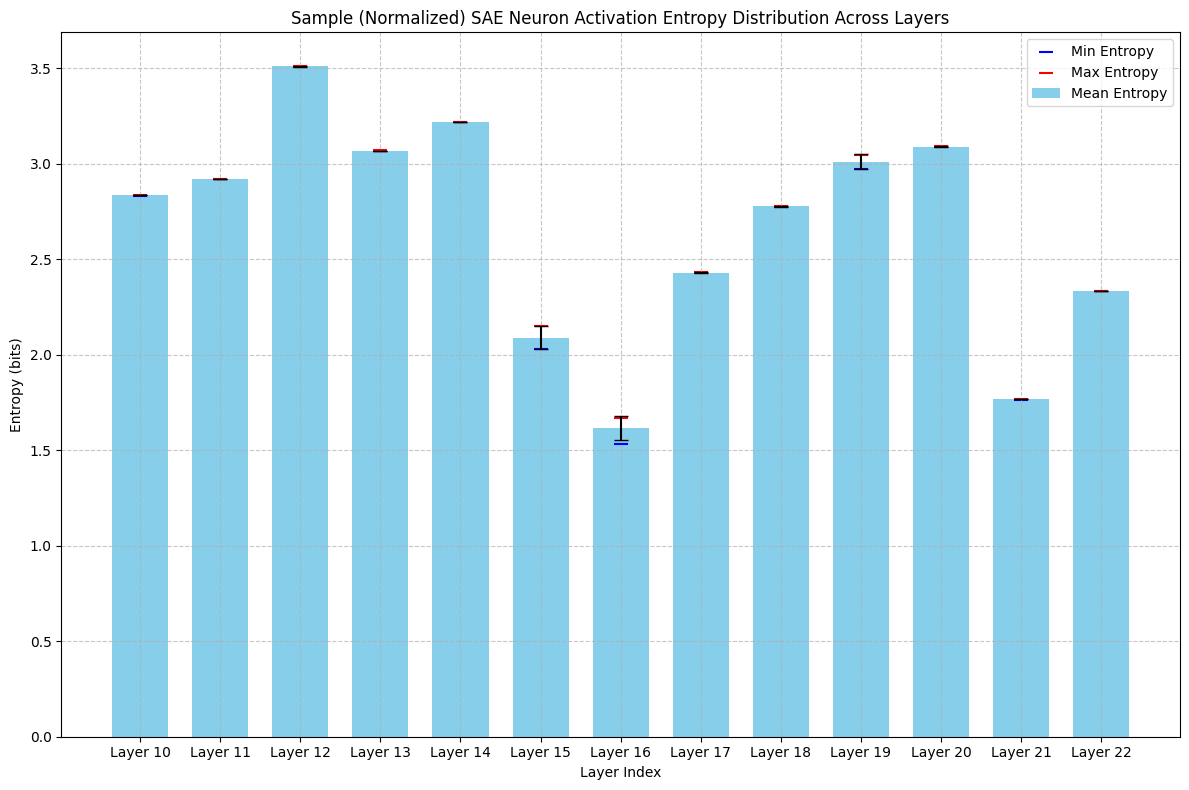

In [55]:
top_ks = measurements[0].top_ks
assert all([
    torch.allclose(m.top_ks, top_ks) for m in measurements
])
entropies = torch.stack([
    m.entropies_no_softmax for m in measurements
])
mean_entropies = entropies.mean(dim=-1)
std_entropies = entropies.std(dim=-1)
min_entropies, _ = entropies.min(dim=-1)
max_entropies, _ = entropies.max(dim=-1)
reconstruction_errors = torch.stack([
    m.top_k_reconstruction_errors for m in measurements
])
top_ks = top_ks.detach().cpu().numpy()
entropies = entropies.detach().cpu().numpy()
mean_entropies = mean_entropies.detach().cpu().numpy()
min_entropies = min_entropies.detach().cpu().numpy()
max_entropies = max_entropies.detach().cpu().numpy()
std_entropies = std_entropies.detach().cpu().numpy()
reconstruction_errors = reconstruction_errors.detach().cpu().numpy()
print("top_ks shape", top_ks.shape)
print("entropies shape", entropies.shape)
print("reconstruction_errors shape", reconstruction_errors.shape)

# Plot entropies as a bar chart with error bars
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))
x = np.arange(len(mean_entropies))
width = 0.7

plt.bar(x, mean_entropies, width, yerr=std_entropies, capsize=5, 
        color='skyblue', label='Mean Entropy')

# Add min/max as scatter points
plt.scatter(x, min_entropies, color='blue', marker='_', s=100, label='Min Entropy')
plt.scatter(x, max_entropies, color='red', marker='_', s=100, label='Max Entropy')

plt.xlabel('Layer Index')
plt.ylabel('Entropy (bits)')
plt.title('Sample (Normalized) SAE Neuron Activation Entropy Distribution Across Layers')
plt.xticks(x, [f'Layer {i+10}' for i in range(len(mean_entropies))])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


(13, 9)
(13, 9)
(13, 9)
(13, 9)


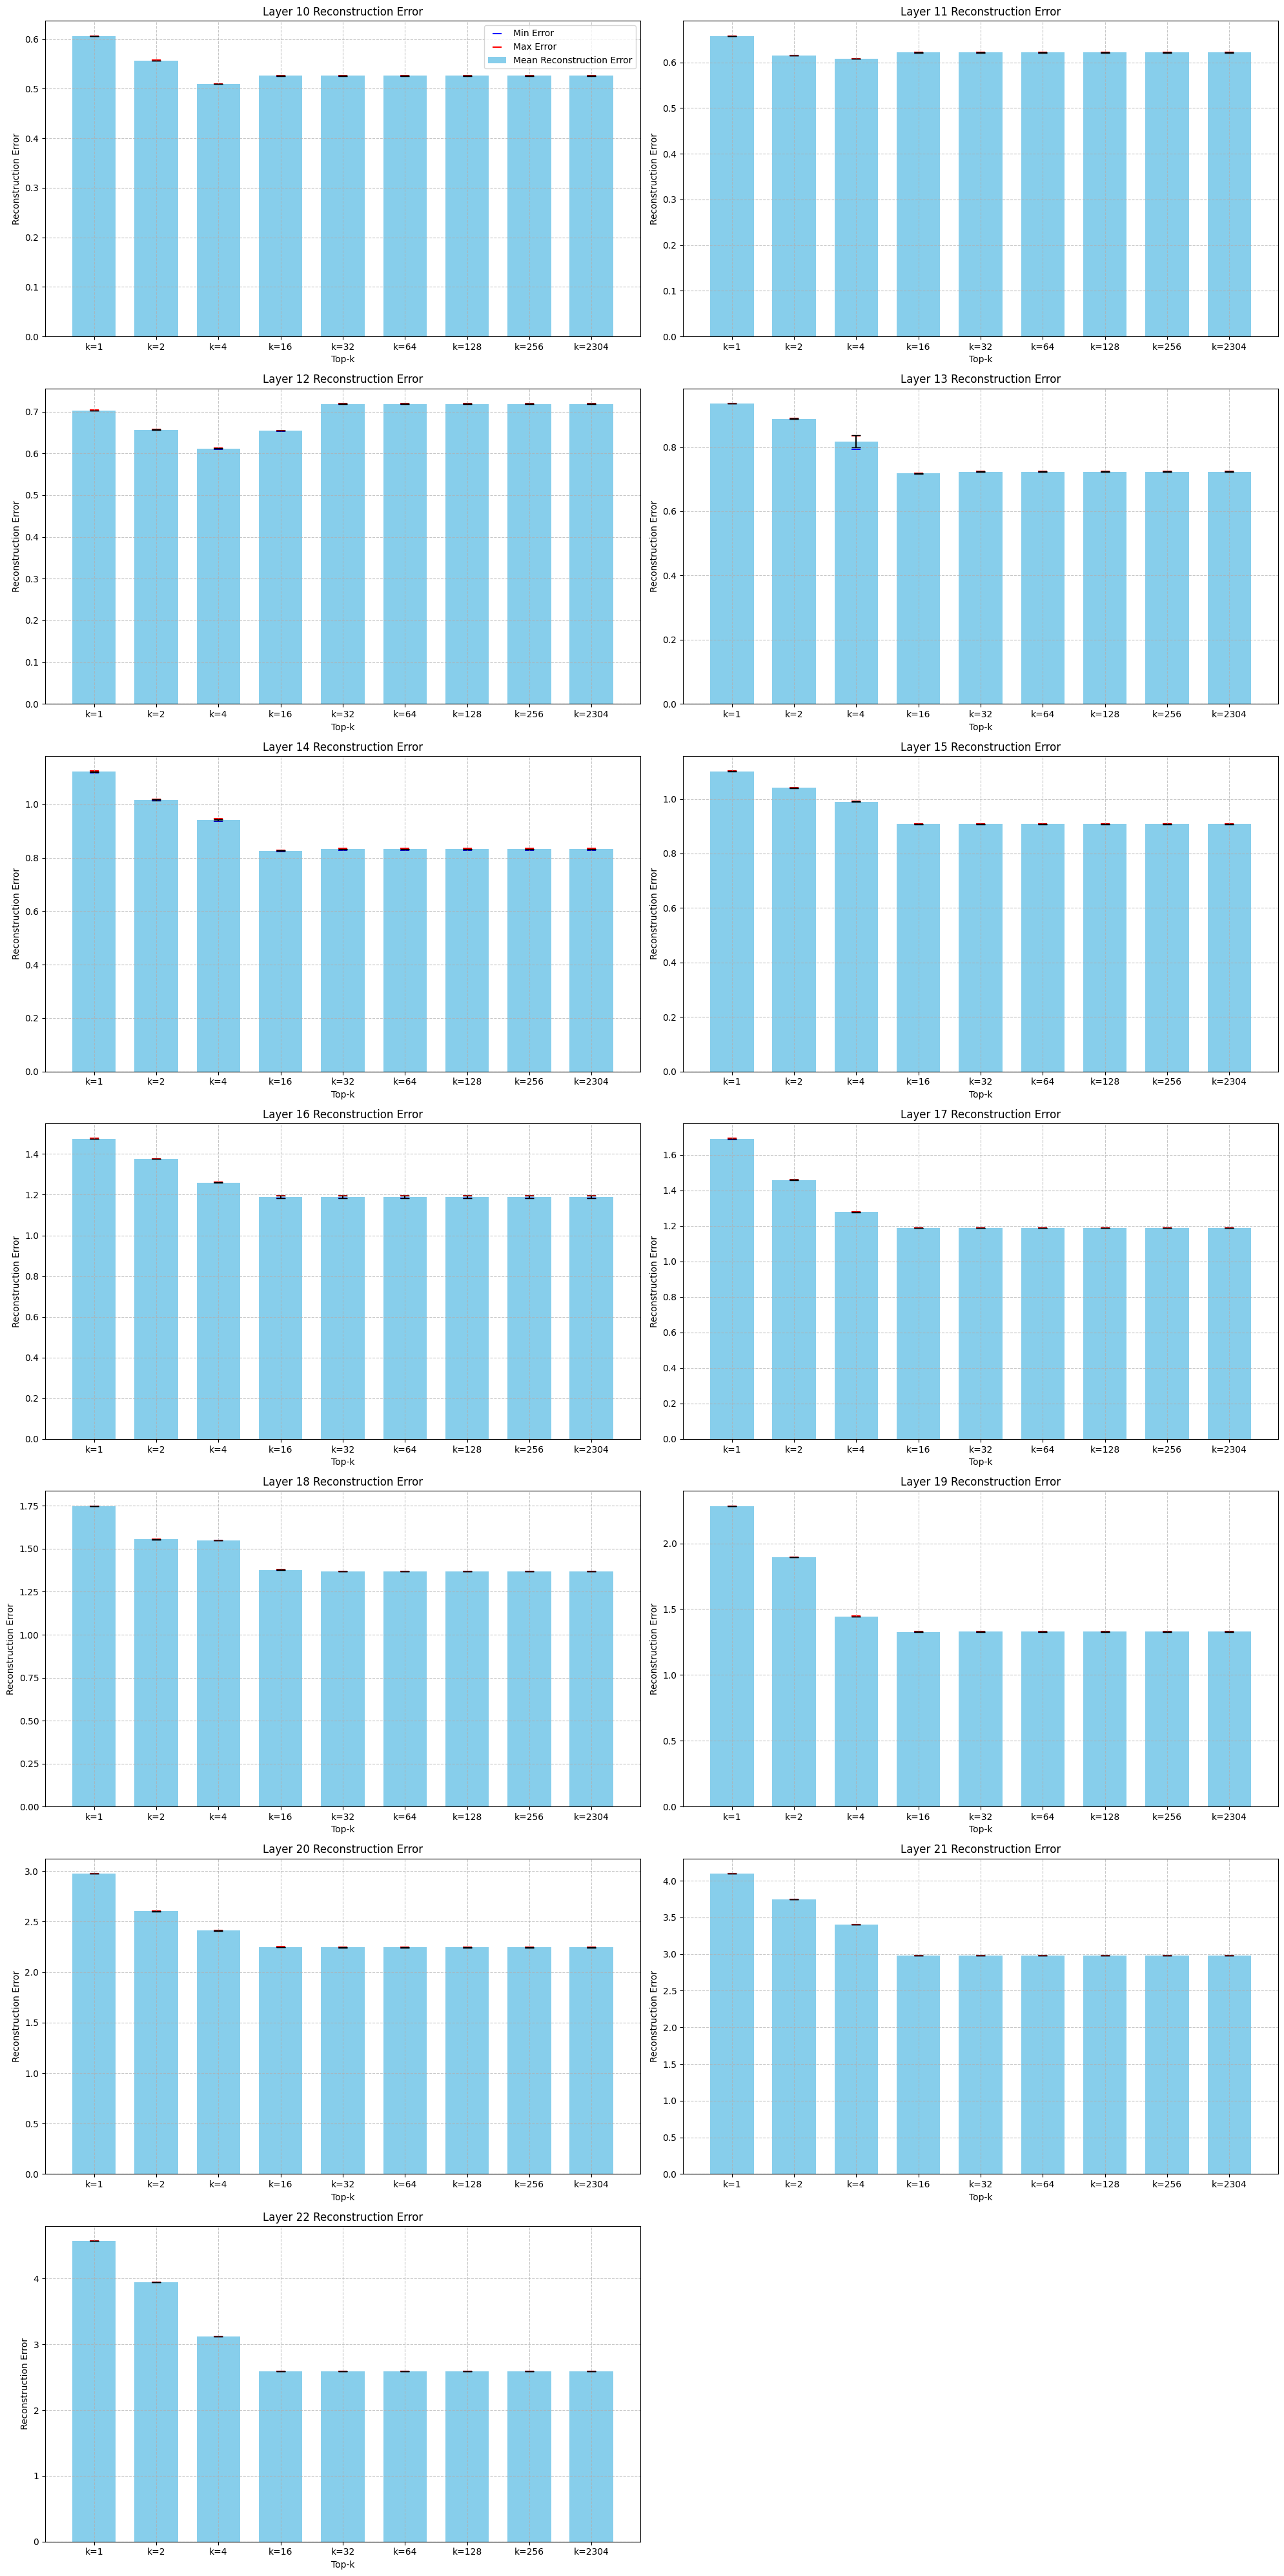

[   1    2    4   16   32   64  128  256 2304]


In [56]:
mean_reconstruction_error_per_k = reconstruction_errors.mean(axis=-1)
stdev_reconstruction_error_per_k = reconstruction_errors.std(axis=-1)
min_reconstruction_error_per_k = reconstruction_errors.min(axis=-1)
max_reconstruction_error_per_k = reconstruction_errors.max(axis=-1)
print(mean_reconstruction_error_per_k.shape)
print(stdev_reconstruction_error_per_k.shape)
print(min_reconstruction_error_per_k.shape)
print(max_reconstruction_error_per_k.shape)
# Create 13 bar charts, one for each layer
plt.figure(figsize=(20, 40))

for i in range(len(mean_reconstruction_error_per_k)):
    plt.subplot(7, 2, i+1)
    
    x = np.arange(len(mean_reconstruction_error_per_k[i]))
    width = 0.7
    
    # Plot bars with error bars
    plt.bar(x, mean_reconstruction_error_per_k[i], width, 
            yerr=stdev_reconstruction_error_per_k[i], 
            capsize=5, color='skyblue', label='Mean Reconstruction Error')
    
    # Add min/max as scatter points
    plt.scatter(x, min_reconstruction_error_per_k[i], color='blue', 
                marker='_', s=100, label='Min Error')
    plt.scatter(x, max_reconstruction_error_per_k[i], color='red', 
                marker='_', s=100, label='Max Error')
    
    plt.xlabel('Top-k')
    plt.ylabel('Reconstruction Error')
    plt.title(f'Layer {i+10} Reconstruction Error')
    plt.xticks(x, [f'k={top_ks[j]}' for j in range(len(top_ks))])
    
    if i == 0:  # Only add legend to the first plot to avoid clutter
        plt.legend()
    
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(top_ks)
